# SkillFactory DataScience
 
## Module_6: Разведывательный анализ данных (Exploratory data analysis) + Feature Engineering (FE) + ML, предсказание цены, градиентный бустинг и стекинг, API, работа с текстом 

## Цель: Научиться подготавливать данные для решения задачи предсказания цены

## Задачи: 
* Совместить два разных набора данных (обучающий и тестовы), которые были собраны независимо
* Попробовать разные методы регрессии
* Попробовать реализовать стекинг

# Результат и выводы

## Краткая информацию о данных
* Данные о товаре (автомобиль) содержали более 30 общих характеристик, часть характеристик была получена из текста (описание товара продавцом)
* Нужно предсказать дефолтных клиентов.
* В качестве скоринга необходимо улучшить MAPE - Mean absolute percentage error. 

## Резултаты (что было проделано)
* Вместо ряда повторяющихся функций, например боксплоты, isna, были написаны вспомогательные циклы. (оригинальный код был без функций).
* Почти все циклы отсутствовали, сейчас код компактнее и понятнее.
* Хотя структура документа совпадает с бейзлайном, но EDA ранее проводилось на каких-то других данных, поэтому пришлось провести заново. Как результат оказалось, что во многих характеристиках использованы разные значения, поэтому пришлось все привести к виду testa.
* Все замены данных traina, используя словари оригинальные и отсутствовали в бейзлайне.
* Также все замены с регулярными выражениями (впервые сам использовал в полях) также мои.
* Поэкспериментировал с onehotencoding и слегка оптимизировал параметры градиентного бустинга.
* Реализовал стекинг для регрессии MAPE: 12.34 % LB 12.01939
* Лучший результат: Без стекинга, градиентный бустинг результат на кагле MAPE=12.50%, Public LB=11.86734, 15 место на лидерборде

## Что еще можно было бы сделать?
* Спарсить свежие данные (к сожалению не хватило времени для тренировки знаний API)
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* стохастический Blending, оптимизировать Stacking
 
 
## Ответ на задание:

1. Kaggle notebook Andrey Pavdivtsev [SF-DST Car Price] , Kaggle никнейм Andrey Pravdivtsev
https://www.kaggle.com/andreypravdivtsev/andrey-pavdivtsev-sf-dst-car-price

2. Kaggle LeaderBoard от 20210221, 15 место Andrey Pravdivtsev скоринг 11.86734

3. https://github.com/AndreyPravdivtsev/SkillFactory-DataScience/tree/master/module_6

4. Какой частью своей работы вы остались особенно довольны?
- EDA, регулярные выражения, словари, функции, почти реализован стекинг

5. Что не получилось сделать так, как хотелось? Над чем ещё стоит поработать?
- Неоптимизирован стекинг
- Неопробован стахастический блендинг.

6. Что является вашим главным результатом при прохождении этого проекта?
- Уверенное владение словарями, первые попытки получения данных из текста


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

from wordcloud import WordCloud, STOPWORDS 
import string
from nltk.util import ngrams
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, ExtraTreesRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

copied from : Submitted by Mitina Natalya 2 months ago @Baseline [SF-DST Car Price prediction] v16

original Public Score
13.68564

бейзлайн из урока не доступен

в этом решении не был доступен частный датасет, только parsing-all-moscow-auto-ru...

In [2]:


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
#DIR_TRAIN  = '../input/my-auto-set/' # подключил к ноутбуку внешний датасет
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/all_auto_ru_09_09_2020.csv' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


In [8]:
#train = pd.read_csv(DIR_TRAIN+'auto_df3.csv', low_memory=False) # датасет для обучения модели
train = pd.read_csv(DIR_TRAIN, low_memory=False) # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(3).T

,0,1,2
bodyType,Седан,Седан,Универсал 5 дв.
brand,AUDI,AUDI,AUDI
color,040001,EE1D19,0000CC
fuelType,бензин,бензин,бензин
modelDate,1990,1982,1988
name,2.8 MT (174 л.с.) 4WD,1.8 MT (90 л.с.),2.3 MT (136 л.с.) 4WD
numberOfDoors,4,4,5
productionDate,1991,1986,1989
vehicleConfiguration,SEDAN MECHANICAL 2.8,SEDAN MECHANICAL 1.8,WAGON_5_DOORS MECHANICAL 2.3
vehicleTransmission,MECHANICAL,MECHANICAL,MECHANICAL


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [11]:
train.isna().sum()

bodyType                    1
brand                       0
color                       0
fuelType                    0
modelDate                   1
name                        1
numberOfDoors               1
productionDate              0
vehicleConfiguration        1
vehicleTransmission         1
engineDisplacement          1
enginePower                 1
description              3254
mileage                     0
Комплектация                0
Привод                      1
Руль                        0
Состояние               89378
Владельцы               13588
ПТС                       361
Таможня                     0
Владение                60177
price                     410
start_date                  0
hidden                  89378
model                       0
dtype: int64

Датасет для обучения содержит 26 признаков и 89377 признака. 


Числовой тип имет цена, количество дверей и дата модели, колличество владельцев, состояние, мощность двигателя, пробег и другие.
Такие данные:
dtypes: bool(1), float64(7), int64(2), object(16)

Много пропущенных значений у признака Владение,description, hidden, состояние, ПТС и price. У остальных данных такие данные в осоновном заполнены. 

У целевого признака price также имеются пропущенные значения. Сразу удалим их и почистим строки, в которых много пропущенных значений

In [12]:
train.dropna(subset=['price', 'bodyType', 'modelDate','name',
                     'numberOfDoors','vehicleConfiguration','vehicleTransmission',
                     'engineDisplacement','Привод'], inplace=True)

In [13]:
train.drop(labels=['hidden'],axis="columns", inplace=True)
# удалим, как пустую колонку

In [14]:
test['ПТС'].value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [15]:
test.head(3).T

,0,1,2
bodyType,лифтбек,лифтбек,лифтбек
brand,SKODA,SKODA,SKODA
car_url,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/superb/11...
color,синий,чёрный,серый
complectation_dict,NaN,NaN,"{""id"":""20026336"",""name"":""Ambition"",""available_..."
description,"Все автомобили, представленные в продаже, прох...",ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,"Все автомобили, представленные в продаже, прох..."
engineDisplacement,1.2 LTR,1.6 LTR,1.8 LTR
enginePower,105 N12,110 N12,152 N12
equipment_dict,"{""engine-proof"":true,""tinted-glass"":true,""airb...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""cruise-control"":true,""tinted-glass"":true,""es..."
fuelType,бензин,бензин,бензин


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [17]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

Тестовый датасет имеет 32 признака (не включая целевую переменную) и 34686 наблюдений. Три признака имеют почти 10000 - 29000 пропущенных значений. 6 признаков имеют числовой формат.


In [18]:
test.priceCurrency.value_counts()

RUB    34686
Name: priceCurrency, dtype: int64

Валюта всех объявлений - рубли. 

In [19]:
test['Состояние'].value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64


Все автомобили не требуют ремонта(Состояние).

In [20]:
test['Таможня'].value_counts()

Растаможен    34686
Name: Таможня, dtype: int64

 И все растоможены(Таможня). 

In [21]:
test['Руль'].value_counts()

Левый     33287
Правый     1399
Name: Руль, dtype: int64

In [22]:
test['ПТС'].value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [23]:
test['vendor'].value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64


##### Бинарные признаки:
руль: при этом левый руль почти у всех(33287), остальные - правый (1399)

ПТС: почти у всех оригинал(30098), остальные - дубликат (4587)

vendor: больше половины европейских машин (20682), остальные - японские (14004)

## Предобработка

In [24]:
#уберем пропущенное значение у ПТС заменив на наиболее часто встречающеся
test['ПТС'] = test['ПТС'].fillna('Оригинал')
train['ПТС'] = train['ПТС'].fillna('Оригинал')

## проверить, может лучше заменить ПТС на дубликат, как подозрение в его отсутствие

Для обучения собрано больше марок автомобилей различного производства. Чтобы не помогать модели на трейне заменим отличных от Европы и Японии производителей на other

In [25]:
train['brand'].value_counts().keys()

Index(['MERCEDES', 'BMW', 'VOLKSWAGEN', 'NISSAN', 'HYUNDAI', 'KIA', 'TOYOTA',
       'FORD', 'AUDI', 'MITSUBISHI', 'CHEVROLET', 'OPEL', 'SKODA', 'RENAULT',
       'MAZDA', 'VOLVO', 'PEUGEOT', 'LAND_ROVER', 'HONDA', 'CITROEN', 'LEXUS',
       'INFINITI', 'DAEWOO', 'SUBARU', 'SUZUKI', 'SSANG_YONG', 'PORSCHE',
       'CHERY', 'JEEP', 'GREAT_WALL', 'DODGE', 'CHRYSLER', 'CADILLAC',
       'JAGUAR', 'MINI', 'GEELY'],
      dtype='object')

In [26]:
test['brand'].value_counts().keys()

Index(['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA', 'AUDI',
       'MITSUBISHI', 'SKODA', 'VOLVO', 'HONDA', 'INFINITI', 'LEXUS'],
      dtype='object')

In [27]:
test['vendor'].value_counts().keys()

Index(['EUROPEAN', 'JAPANESE'], dtype='object')

In [28]:
test[test.brand=="MAZDA"]['vendor'].value_counts().keys()

Index([], dtype='object')

In [29]:
vendor_dict={'MERCEDES':"EUROPEAN", 'BMW':"EUROPEAN", 'VOLKSWAGEN':"EUROPEAN", 
      'NISSAN':"JAPANESE", 'HYUNDAI':"OTHER", 'KIA':"OTHER", 'TOYOTA':"JAPANESE",
       'FORD':"USA", 'AUDI':"EUROPEAN", 'MITSUBISHI':"JAPANESE", 'CHEVROLET':"USA",
       'OPEL':"EUROPEAN", 'SKODA':"EUROPEAN", 'RENAULT':"EUROPEAN",
       'MAZDA':"JAPANESE", 'VOLVO':"EUROPEAN", 'PEUGEOT':"EUROPEAN", 
       'LAND_ROVER':"EUROPEAN", 'HONDA':"JAPANESE", 'CITROEN':"EUROPEAN", 'LEXUS':"JAPANESE",
       'INFINITI':"JAPANESE", 'DAEWOO':"OTHER", 'SUBARU':"JAPANESE", 'SUZUKI':"JAPANESE", 'SSANG_YONG':"OTHER", 'PORSCHE':"EUROPEAN",
       'CHERY':"OTHER", 'JEEP':"USA", 'GREAT_WALL':"OTHER", 'DODGE':"USA", 'CHRYSLER':"USA", 'CADILLAC':"USA",
       'JAGUAR':"EUROPEAN", 'MINI':"EUROPEAN", 'GEELY':"OTHER"}

In [30]:
train['vendor']=train['brand'].map(vendor_dict)

In [31]:
train['vendor'] = train['vendor'].apply(lambda x: x if x == 'EUROPEAN' else( x if x == 'JAPANESE' else 'other'))

Проверим и удалим сразу признаки, которые принимают только одно значение: Состояние, Таможня и priceCurrency (верно для test ds)

In [32]:
s1=[]
for c in train.columns:
    if len(train[c].unique())==1:
        print(f"{c} number of uniq values 1")
        s1.append(c)
train.drop(s1, axis=1, inplace=True)

Состояние number of uniq values 1
Таможня number of uniq values 1


In [33]:
s1=[]
for c in test.columns:
    if len(test[c].unique())==1:
        print(f"{c} number of uniq values 1")
        s1.append(c)
test.drop(s1, axis=1, inplace=True)

priceCurrency number of uniq values 1
Состояние number of uniq values 1
Таможня number of uniq values 1


In [34]:
# промежуточная проверка признаков

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88967 entries, 0 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              88967 non-null  object 
 1   brand                 88967 non-null  object 
 2   color                 88967 non-null  object 
 3   fuelType              88967 non-null  object 
 4   modelDate             88967 non-null  float64
 5   name                  88967 non-null  object 
 6   numberOfDoors         88967 non-null  float64
 7   productionDate        88967 non-null  int64  
 8   vehicleConfiguration  88967 non-null  object 
 9   vehicleTransmission   88967 non-null  object 
 10  engineDisplacement    88967 non-null  object 
 11  enginePower           88967 non-null  float64
 12  description           85733 non-null  object 
 13  mileage               88967 non-null  int64  
 14  Комплектация          88967 non-null  object 
 15  Привод             

In [36]:
# Поменяем на числовой формат признаки в соответствии с тестовым датасетом
train['productionDate'] = train['productionDate'].values.astype('int64')
#train['sell_id'] = train['sell_id'].values.astype('int64')
train['modelDate'] = train['modelDate'].values.astype('int64')
train['numberOfDoors'] = train['numberOfDoors'].values.astype('int64')
train['enginePower'] = train['enginePower'].values.astype('int64')
train['Владельцы'] = train['Владельцы'].values.astype('int64')
#train['parsing_unixtime'] = train['parsing_unixtime'].apply(lambda x: x.replace('.0', ''))
#train['parsing_unixtime'] = train['parsing_unixtime'].values.astype('int64')

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88967 entries, 0 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              88967 non-null  object 
 1   brand                 88967 non-null  object 
 2   color                 88967 non-null  object 
 3   fuelType              88967 non-null  object 
 4   modelDate             88967 non-null  int64  
 5   name                  88967 non-null  object 
 6   numberOfDoors         88967 non-null  int64  
 7   productionDate        88967 non-null  int64  
 8   vehicleConfiguration  88967 non-null  object 
 9   vehicleTransmission   88967 non-null  object 
 10  engineDisplacement    88967 non-null  object 
 11  enginePower           88967 non-null  int64  
 12  description           85733 non-null  object 
 13  mileage               88967 non-null  int64  
 14  Комплектация          88967 non-null  object 
 15  Привод             

In [38]:
test['enginePower'].value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
42 N12        1
40 N12        1
591 N12       1
164 N12       1
195 N12       1
Name: enginePower, Length: 315, dtype: int64

In [39]:
#train['enginePower'] = train['enginePower'].apply(lambda x: x.replace(' N12', ''))
test['enginePower'] = test['enginePower'].apply(lambda x: x.replace(' N12', ''))

train['enginePower'] = train['enginePower'].values.astype('int64')
test['enginePower'] = test['enginePower'].values.astype('int64')

In [40]:
train.mileage.describe()

count      88967.000000
mean      134826.642991
std       103020.880462
min            0.000000
25%        56000.000000
50%       130000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [41]:
sum(train.mileage.isna())

0

Минимальное значение пробега 0 - что не логично. Даже у новых машин из салона пробег 10-30 км. Поменяем формат с float64 на int64

In [42]:
#train['mileageNAN'] = pd.isna(train['mileage']).astype('int64')
train['mileage'] = train['mileage'].fillna('0')
#train['mileage'] = train['mileage'].apply(lambda x: str(x).replace(':', '') if ':' in x else x)
train['mileage'] = train['mileage'].values.astype('int64')
# и поменяем тип price
train.price = train.price.values.astype('float32')

In [43]:
#train['mileageNAN'] = train['mileage'].apply(lambda x: 1 if x == 0 else 0)

вспомогательные функции

In [44]:
def plot_my_boxplot(x='bodyType2',y='log_price',title="price of bodyTypes"):
    plt.figure(figsize=(8, 5))
    g1 = sns.boxplot(y=y, x=x, 
                      data=train, color='darkgreen')
    g1.set_title(title, fontsize=20)
    ylabel=y
    g1.set_ylabel(ylabel, fontsize=15)
    g1.set_xlabel(x, fontsize=15)
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45, fontsize=10)
    plt.show()
    
def check_na(x="bodyType2"):
    print(f"col = {x};\nisna_train = {train[x].isna().sum()}\nisna_test = {test[x].isna().sum()}")

## EDA
 рассмотрим все признаки по отдельности

### 1. bodyType

In [45]:
check_na("bodyType")

col = bodyType;
isna_train = 0
isna_test = 0


In [46]:
train.bodyType.value_counts()

Внедорожник 5 дв.                  31748
Седан                              30458
Хэтчбек 5 дв.                       8613
Универсал 5 дв.                     3370
Лифтбек                             3111
                                   ...  
Внедорожник 5 дв. Trackhawk            1
Седан LWB                              1
Универсал 5 дв. Spaceback              1
Пикап Полуторная кабина Rap Cab        1
Хэтчбек 5 дв. EU                       1
Name: bodyType, Length: 168, dtype: int64

In [47]:
train['bodyType2'] = train.bodyType
train['bodyType2'] = train['bodyType2'].apply(lambda x: x.lower())
bodyType = train.bodyType2.value_counts()[:9]
bodyType

внедорожник 5 дв.    31748
седан                30458
хэтчбек 5 дв.         8613
универсал 5 дв.       3370
лифтбек               3111
компактвэн            1905
минивэн               1807
хэтчбек 3 дв.         1372
купе                  1286
Name: bodyType2, dtype: int64

In [48]:

test['bodyType2'] = test.bodyType
test['bodyType2'] = test['bodyType2'].apply(lambda x: x.lower())
bodyType_test = test.bodyType.value_counts()[:9]
bodyType_test

седан                13147
внедорожник 5 дв.    12228
лифтбек               2232
хэтчбек 5 дв.         2124
универсал 5 дв.       1276
минивэн                995
купе                   824
компактвэн             489
хэтчбек 3 дв.          485
Name: bodyType, dtype: int64

In [49]:
set(bodyType_test.index)-set(bodyType.index)

set()

In [50]:
set(bodyType.index)-set(bodyType_test.index)

set()

In [51]:
set(bodyType.index)==set(bodyType_test.index)

True

9 основных типов машин в трейне и тесте совпадают

Выделим 9 основных, остальные заменим общим типом "другой"

In [52]:
train['bodyType2'] = train['bodyType2'].apply(lambda x: x if x in bodyType else 'другой')
test['bodyType2'] = test['bodyType2'].apply(lambda x: x if x in bodyType else 'другой')

Проверим что все верно

In [53]:
test['bodyType2'].value_counts()

седан                13147
внедорожник 5 дв.    12228
лифтбек               2232
хэтчбек 5 дв.         2124
универсал 5 дв.       1276
минивэн                995
другой                 886
купе                   824
компактвэн             489
хэтчбек 3 дв.          485
Name: bodyType2, dtype: int64

In [54]:
test['bodyType2'].value_counts()

седан                13147
внедорожник 5 дв.    12228
лифтбек               2232
хэтчбек 5 дв.         2124
универсал 5 дв.       1276
минивэн                995
другой                 886
купе                   824
компактвэн             489
хэтчбек 3 дв.          485
Name: bodyType2, dtype: int64

In [55]:
set(test['bodyType2'].value_counts().index)==set(train['bodyType2'].value_counts().index)

True

Так как большой разбег по стоимости, то построим зависимость от логарифма цены

In [56]:
train['log_price'] = np.log(train.price)

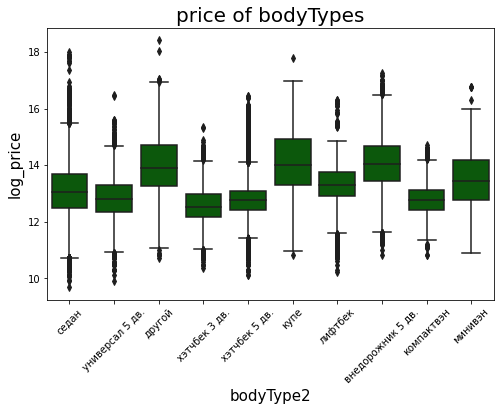

In [57]:
plot_my_boxplot(x='bodyType2',y='log_price',title="price of bodyTypes")

В целом есть зависимость типа машин от стоимости. 

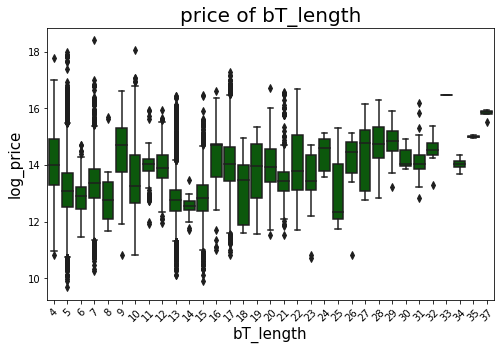

In [58]:
#добавим столбец длины названия типа кузова
train = train.assign(bT_length = train['bodyType'].apply(len))
test = test.assign(bT_length = test['bodyType'].apply(len))
plot_my_boxplot(x='bT_length',y='log_price',title="price of bT_length")

In [59]:
test.drop(["bodyType"],axis="columns", inplace=True)
train.drop(["bodyType"],axis="columns", inplace=True)

### 2. brand

In [60]:
check_na(x="brand")

col = brand;
isna_train = 0
isna_test = 0


In [61]:
len(train.brand.value_counts())

36

In [62]:
train.brand.value_counts().index

Index(['MERCEDES', 'BMW', 'VOLKSWAGEN', 'NISSAN', 'HYUNDAI', 'KIA', 'TOYOTA',
       'FORD', 'AUDI', 'MITSUBISHI', 'CHEVROLET', 'OPEL', 'SKODA', 'RENAULT',
       'MAZDA', 'VOLVO', 'PEUGEOT', 'LAND_ROVER', 'HONDA', 'CITROEN', 'LEXUS',
       'INFINITI', 'DAEWOO', 'SUBARU', 'SUZUKI', 'SSANG_YONG', 'PORSCHE',
       'CHERY', 'JEEP', 'GREAT_WALL', 'DODGE', 'CHRYSLER', 'CADILLAC',
       'JAGUAR', 'MINI', 'GEELY'],
      dtype='object')

In [63]:
len(test.brand.value_counts())

12

31 уникальный бренд в трейне и 12 в тесте

In [64]:
brand = set(test.brand.value_counts().index)
brand-set(train.brand.value_counts().index[:12])

{'HONDA', 'INFINITI', 'LEXUS', 'SKODA', 'VOLVO'}

Основные бредны машин не совпадают. Оставим те, что есть в тесте, остальные объединим общей категорией

In [65]:
train['brand'] = train['brand'].apply(lambda x: x if x in brand else 'other')

In [66]:
set(train['brand'].value_counts().index)-brand

{'other'}

ok

In [67]:
train.groupby('brand').price.describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
AUDI,4070.0,1.502618e+06,1.613055e+06,25000.0,456000.00,920000.0,1899553.25,14898500.0
BMW,7365.0,2.387444e+06,2.130623e+06,60000.0,800000.00,1650000.0,3349800.00,16290000.0
HONDA,1172.0,5.957942e+05,4.719355e+05,40000.0,325000.00,480000.0,740000.00,5697338.0
INFINITI,1036.0,1.564960e+06,1.192107e+06,105000.0,699749.25,1200000.0,1833000.00,5985000.0
LEXUS,1046.0,2.025738e+06,1.470398e+06,170000.0,900000.00,1650000.0,2766500.00,11800000.0
MERCEDES,7979.0,3.526259e+06,4.224981e+06,40000.0,870000.00,2100000.0,4800000.00,68500000.0
MITSUBISHI,3919.0,9.940350e+05,8.224992e+05,38000.0,280000.00,650000.0,1847750.00,3500000.0
NISSAN,5750.0,8.913853e+05,6.984599e+05,25000.0,370000.00,650000.0,1269750.00,7500000.0
SKODA,2795.0,6.573264e+05,4.008630e+05,20000.0,409995.00,565000.0,799000.00,2906440.0


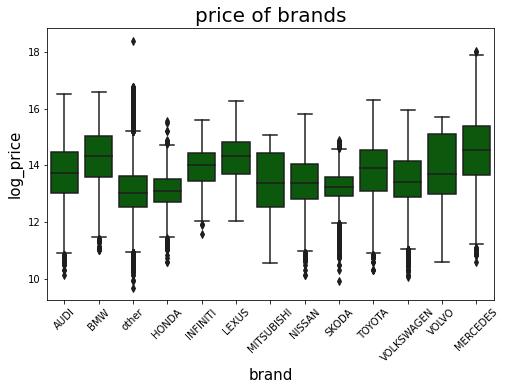

In [68]:
plot_my_boxplot(x='brand',y='log_price',title="price of brands")

Одни из самых дорогих машин - lexus, mersedes, bmw, что ожидаемо. Часть машин в общей ценовой категории примерно (vw, nissan, mitsubishi и honda, остальные промужоточный диапазон

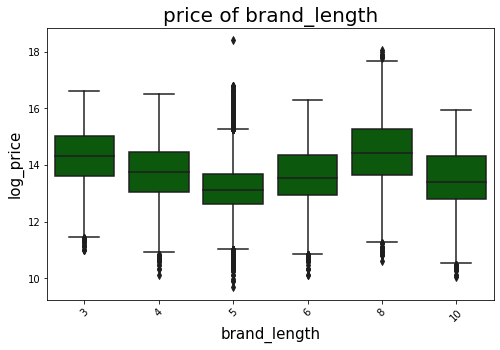

In [69]:
#добавим столбец длины бренда
train = train.assign(brand_length = train['brand'].apply(len))
test = test.assign(brand_length = test['brand'].apply(len))
plot_my_boxplot(x='brand_length',y='log_price',title="price of brand_length")

### 3. model_name

In [70]:
len(test.model_name.value_counts())

544

In [71]:
train.rename(columns={"model": "model_name"},inplace=True)

In [72]:
check_na(x="model_name")

col = model_name;
isna_train = 0
isna_test = 0


In [73]:
len(train.model_name.value_counts())

1086

544 модели машин в тесте и 1086 в трейне. 

In [74]:
test.model_name.value_counts().head(15)

OCTAVIA      1418
5ER          1026
LANCER        855
E_KLASSE      809
PASSAT        782
A6            757
3ER           752
POLO          724
CAMRY         709
X5            675
X_TRAIL       654
A4            626
QASHQAI       609
S_KLASSE      549
OUTLANDER     544
Name: model_name, dtype: int64

In [75]:
train.model_name.value_counts().head(15)

FOCUS        2458
SOLARIS      1763
5ER          1669
ASTRA        1543
OCTAVIA      1492
RIO          1463
E_KLASSE     1426
3ER          1414
PASSAT       1394
OUTLANDER    1367
POLO         1292
X_TRAIL      1151
TIGUAN       1033
X5            942
QASHQAI       940
Name: model_name, dtype: int64

### 4. model_info

In [76]:
test.model_info.sample(5)

3204     {"code":"Q7","name":"Q7","ru_name":"Ку7","morp...
18306    {"code":"GL_KLASSE","name":"GL-Класс","ru_name...
18925    {"code":"C_KLASSE","name":"C-Класс","ru_name":...
22874    {"code":"GS","name":"GS","ru_name":"GS","morph...
17288    {"code":"G_KLASSE_AMG","name":"G-Класс AMG","r...
Name: model_info, dtype: object

model_info дублирует model_name. Можно удалить этот признак

In [77]:
test.drop(["model_info"],axis="columns", inplace=True)

### 5. car_url

In [78]:
test.car_url

0        https://auto.ru/cars/used/sale/skoda/octavia/1...
1        https://auto.ru/cars/used/sale/skoda/octavia/1...
2        https://auto.ru/cars/used/sale/skoda/superb/11...
3        https://auto.ru/cars/used/sale/skoda/octavia/1...
4        https://auto.ru/cars/used/sale/skoda/octavia/1...
                               ...                        
34681    https://auto.ru/cars/used/sale/bmw/3er/1101369...
34682    https://auto.ru/cars/used/sale/bmw/5er/1101369...
34683    https://auto.ru/cars/used/sale/bmw/5er/1101364...
34684    https://auto.ru/cars/used/sale/bmw/x1/11013625...
34685    https://auto.ru/cars/used/sale/bmw/x5/11012560...
Name: car_url, Length: 34686, dtype: object

удаляем, не очевидно, какую новую информацию можно получить, кроме сайта.

In [79]:
test.drop(["car_url"],axis="columns", inplace=True)

### 6. complectation_dict

Признак содержит 28268 пропущенных значений в тесте

In [80]:
# отсутствует 81% значений
test.complectation_dict.isna().sum() / len(test.complectation_dict)

0.8149685752176671

In [81]:
test.complectation_dict.sample(5)

7599                                                   NaN
14900    {"id":"2482969","name":"Sport","available_opti...
7970     {"id":"21765705","name":"218i M Sport Pro","av...
28234                                                  NaN
25448    {"id":"20678628","name":"Trendline","available...
Name: complectation_dict, dtype: object

In [82]:
train.rename(columns={"Комплектация": "complectation_dict"},inplace=True)
train["complectation_dict"].sample(5)

47476                                          {'id': '0'}
19102                                          {'id': '0'}
44404    {'id': '21795176', 'name': 'Ultimate (Beige)',...
21710                                          {'id': '0'}
36183    {'id': '21079682', 'name': 'Premium', 'availab...
Name: complectation_dict, dtype: object

In [83]:
train.complectation_dict.value_counts().sample(1)

{'id': '20338362', 'name': 'Titanium', 'available_options': ['cruise-control', 'multi-wheel', 'airbag-passenger', 'roof-rails', 'lock', 'electro-mirrors', 'mirrors-heat', 'volume-sensor', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'abs', 'wheel-leather', 'climate-control-1', 'tinted-glass', 'esp', 'usb', 'audiopreparation', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'body-mouldings', 'condition', 'park-assist-r', 'knee-airbag', 'airbag-driver', 'isofix', 'aux', 'electro-window-front', 'airbag-curtain', 'alarm', 'ptf', 'voice-recognition', 'audiosystem-cd', 'front-seats-heat', 'bluetooth', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'windscreen-heat'], 'vendor_colors': [{'body_color_id': 20635924, 'mark_color_id': 21388338, 'name_ru': 'Panther Black', 'color_type': 'METALLIC', 'stock_color': {'hex_code': '040001', 'name_ru': 'черный'}, 'photos': [{'name': '34-front', 'sizes': {'orig': '//avatars.mds.yandex.net/get-verba/787013/2a0

In [84]:
test.complectation_dict.value_counts().sample(1)

{"id":"21075643","name":"xDrive30d Prestige","available_options":["cruise-control","sport-seats","multi-wheel","xenon","airbag-passenger","navigation","lock","electro-mirrors","mirrors-heat","leather","seat-memory","start-stop-function","automatic-lighting-control","computer","seat-transformation","light-cleaner","airbag-side","electro-trunk","abs","wheel-leather","climate-control-1","auto-mirrors","esp","usb","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","rear-camera","servo","steering-wheel-gear-shift-paddles","electro-window-back","park-assist-f","19-inch-wheels","wheel-heat","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","airbag-curtain","passenger-seat-electric","paint-metallic","start-button","ptf","rain-sensor","audiosystem-cd","front-seats-heat","bluetooth","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"],"vendor_colors":[{"body_color_id":21489210,"mark_

Судя по данным - этот признак частично содержит информацию об опциях машины. Но сложно понять - все ли опции есть в машинах и как это классифицировать id. За неимением информации о признаке и  большом количестве пропусков - удалим признак

In [85]:
test.drop(["complectation_dict"],axis="columns", inplace=True)
train.drop(["complectation_dict"],axis="columns", inplace=True)

### 7. equipment_dict

In [86]:
# отсутствует 29% значений
test.equipment_dict.isna().sum() / len(test.equipment_dict)

0.2881854350458398

In [87]:
test.equipment_dict.value_counts().sample(10)

{"cruise-control":true,"tinted-glass":true,"esp":true,"multi-wheel":true,"xenon":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"front-centre-armrest":true,"lock":true,"servo":true,"drl":true,"electro-mirrors":true,"electro-window-back":true,"easy-trunk-opening":true,"driver-seat-support":true,"reduce-spare-wheel":true,"mirrors-heat":true,"17-inch-wheels":true,"dark-interior":true,"park-assist-f":true,"driver-seat-updown":true,"wheel-heat":true,"park-assist-r":true,"engine-proof":true,"start-stop-function":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"light-sensor":true,"hcc":true,"automatic-lighting-control":true,"airbag-curtain":true,"computer":true,"programmed-block-heater":true,"alarm":true,"passenger-seat-electric":true,"light-cleaner":true,"fabric-seats":true,"ptf":true,"start-button":true,"rain-sensor":true,"airbag-side":true,"tyre-pressure":true,"audiosystem-cd":true,"electronic-gage-panel":true,"electro-trunk":true,"abs":tru

Почти 20000 данных этого признака в трейне отсутствует. Часть данных имеет ограниченное описание, так как у машин с кожаным салоном наверняка присутствуют и другие новшества и удобства. Тоже удаляем

In [88]:
test.drop(["equipment_dict"],axis="columns", inplace=True)

### 8. name

In [89]:
test.name.sample(3)

32505    3.5 CVT (249 л.с.) 4WD
33993         2.0 MT (136 л.с.)
8456     520i 2.0 MT (150 л.с.)
Name: name, dtype: object

Данная информация содержится в других признаках отдельно, например, vehicleTransmission, enginePower, engineDisplacement. Удаляем.

In [90]:
train.drop(["name"],axis="columns", inplace=True)
test.drop(["name"],axis="columns", inplace=True)

### 9. enginePower 

In [91]:
test['enginePower'].describe

<bound method NDFrame.describe of 0        105
1        110
2        152
3        110
4        152
        ... 
34681    136
34682    190
34683    170
34684    184
34685    235
Name: enginePower, Length: 34686, dtype: int64>

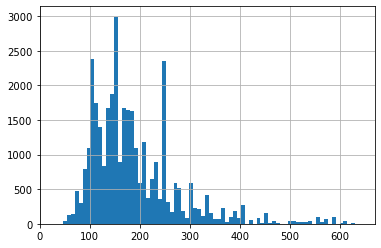

In [92]:
test['enginePower'].hist(bins=77)

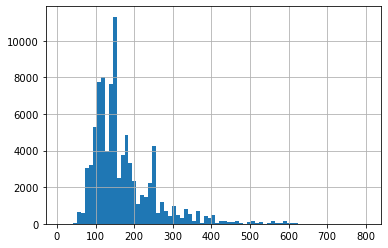

In [93]:
train['enginePower'].hist(bins=77)

In [94]:
train.enginePower.describe()

count    88967.000000
mean       171.241089
std         83.509899
min         11.000000
25%        115.000000
50%        150.000000
75%        199.000000
max        800.000000
Name: enginePower, dtype: float64

In [95]:
train[train.enginePower < 30]

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,...,ПТС,Владение,price,start_date,model_name,vendor,bodyType2,log_price,bT_length,brand_length
22691,other,007F00,бензин,1908,2,1923,CABRIO MECHANICAL 2.9,MECHANICAL,2.9,20,...,ORIGINAL,NaN,3800000.0,2018-12-26T17:36:01Z,MODEL_T,other,другой,15.150512,9,5
22692,other,040001,бензин,1908,2,1924,CABRIO MECHANICAL 2.9,MECHANICAL,2.9,20,...,ORIGINAL,NaN,3000000.0,2020-08-10T11:12:36Z,MODEL_T,other,другой,14.914123,9,5
59955,other,FAFBFB,электро,2011,2,2012,COUPE AUTOMATIC Electro,AUTOMATIC,Electro,17,...,ORIGINAL,"{'year': 2018, 'month': 11}",449000.0,2020-07-06T10:09:12Z,TWIZY,EUROPEAN,купе,13.014778,4,5
59956,other,040001,электро,2011,2,2016,COUPE AUTOMATIC Electro,AUTOMATIC,Electro,11,...,ORIGINAL,"{'year': 2018, 'month': 10}",549000.0,2020-07-22T17:18:07Z,TWIZY,EUROPEAN,купе,13.215854,4,5


Раритетные (и маленькие электрические) машины имеют маленькую мощность, это вполне возможно

In [96]:
train[train.enginePower > 600]

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,...,ПТС,Владение,price,start_date,model_name,vendor,bodyType2,log_price,bT_length,brand_length
3952,AUDI,0000CC,бензин,2015,2,2015,COUPE ROBOT V10,ROBOT,V10,610,...,ORIGINAL,"{'year': 2018, 'month': 3}",7600000.0,2020-07-29T14:48:19Z,R8,EUROPEAN,купе,15.843658,4,4
3965,AUDI,4A2197,бензин,2014,5,2017,WAGON_5_DOORS AUTOMATIC 4.0,AUTOMATIC,4.0,605,...,ORIGINAL,NaN,5860750.0,2020-06-07T13:14:36Z,RS6,EUROPEAN,универсал 5 дв.,15.583788,15,4
3968,AUDI,EE1D19,бензин,2014,5,2017,WAGON_5_DOORS AUTOMATIC 4.0,AUTOMATIC,4.0,605,...,ORIGINAL,NaN,5699000.0,2020-08-15T13:36:29Z,RS6,EUROPEAN,универсал 5 дв.,15.555801,15,4
3969,AUDI,97948F,бензин,2014,5,2017,WAGON_5_DOORS AUTOMATIC 4.0,AUTOMATIC,4.0,605,...,ORIGINAL,NaN,5999000.0,2020-08-10T19:15:21Z,RS6,EUROPEAN,универсал 5 дв.,15.607103,15,4
3973,AUDI,0000CC,бензин,2014,5,2017,WAGON_5_DOORS AUTOMATIC 4.0,AUTOMATIC,4.0,605,...,ORIGINAL,NaN,5598000.0,2020-06-16T09:17:08Z,RS6,EUROPEAN,универсал 5 дв.,15.537920,15,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88051,MERCEDES,FAFBFB,бензин,2017,2,2019,COUPE AUTOMATIC 63,AUTOMATIC,63,612,...,ORIGINAL,NaN,11661200.0,2019-12-27T11:15:56Z,S_KLASSE_AMG,EUROPEAN,купе,16.271778,4,8
88052,MERCEDES,040001,бензин,2017,2,2019,COUPE AUTOMATIC 63,AUTOMATIC,63,612,...,ORIGINAL,NaN,14967400.0,2020-07-10T10:13:09Z,S_KLASSE_AMG,EUROPEAN,купе,16.521385,4,8
88059,MERCEDES,040001,бензин,2017,2,2018,COUPE AUTOMATIC 63,AUTOMATIC,63,612,...,ORIGINAL,"{'year': 2018, 'month': 5}",13800000.0,2020-09-05T11:02:42Z,S_KLASSE_AMG,EUROPEAN,купе,16.440180,4,8
88160,MERCEDES,CACECB,бензин,2003,2,2005,COUPE AUTOMATIC 5.4,AUTOMATIC,5.4,626,...,ORIGINAL,"{'year': 2008, 'month': 9}",22800000.0,2020-07-13T10:14:41Z,SLR_KLASSE,EUROPEAN,купе,16.942270,4,8


Верхняя граница тоже выглядит вполне естественной

In [97]:
train['log_power'] = np.log(train.enginePower)
test['log_power'] = np.log(test.enginePower)

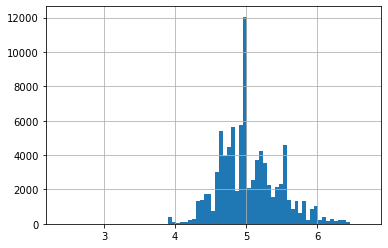

In [98]:
train['log_power'].hist(bins=77)

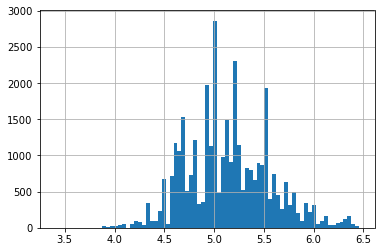

In [99]:
test['log_power'].hist(bins=77)

# проверить Логарифмирование мощности метрику не улучшило.Попробеум ввести признак соответствующий налогу в зависимости от мощности

In [100]:
# Разобьем мощность двигателей согласно налоговым интервалам
bins =       [0, 100, 125, 150,  175,  200,  225,  250,  800]
nbin_labels = [12,   25,  35,  45,   50,   65,   75, 150]

Создав в разбиении категорию для раритетных машин

In [101]:
#налоговая база
train['Nalog_base']=pd.cut(train['enginePower'],bins,labels=nbin_labels)
test['Nalog_base']=pd.cut(test['enginePower'],bins,labels=nbin_labels)
train['Nalog_base'] = train['Nalog_base'].values.astype('int64')
test['Nalog_base'] = test['Nalog_base'].values.astype('int64')
train[['Nalog_base','enginePower']]

,Nalog_base,enginePower
0,45,174
1,12,90
2,35,136
3,12,90
4,25,101
...,...,...
89373,45,163
89374,45,163
89375,35,149
89376,35,149


In [102]:
train['Nalog'] = train['enginePower'] * train['Nalog_base']
test['Nalog'] = test['enginePower'] * test['Nalog_base']

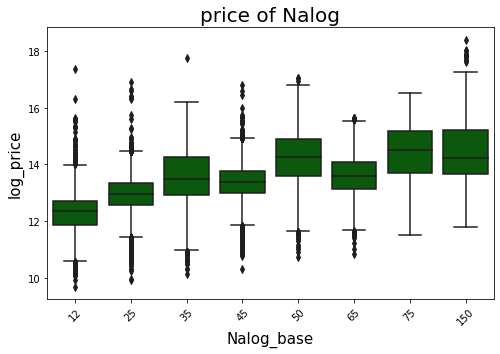

In [103]:
plot_my_boxplot(x='Nalog_base',y='log_price',title="price of Nalog")

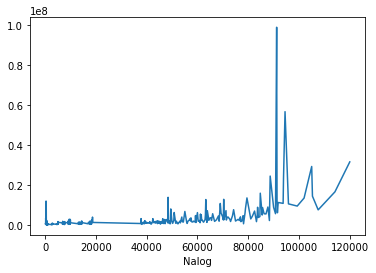

In [104]:
train.groupby('Nalog').price.mean().plot()

Налоговая база и налог вырастают с ростом цены автомобиля

### 10. engineDisplacement

In [105]:
test.engineDisplacement.value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
3.8 LTR      57
1.0 LTR      57
 LTR         55
2.6 LTR      55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

In [106]:
#test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x.split()[0])
test["engineDisplacement"]=test.engineDisplacement.apply(lambda x: 
                                             re.search('\d.\d',x).group(0) if re.search('\d.\d',x) else np.nan)
test.engineDisplacement.value_counts()

2.0    7391
1.6    4973
3.0    3915
1.8    3349
2.5    2477
2.4    1745
3.5    1710
1.4    1635
1.5     725
1.2     485
4.4     447
2.8     384
4.7     377
1.3     365
5.5     361
4.0     356
3.2     348
4.5     346
2.1     271
3.7     242
2.2     236
4.2     228
1.9     221
2.3     203
2.7     189
3.6     183
5.6     170
5.0     158
5.7     135
2.9     131
4.6     108
3.1      88
4.8      84
1.7      59
3.8      57
1.0      57
2.6      55
6.0      53
0.7      53
3.3      44
3.4      36
4.1      35
4.3      32
5.4      31
6.2      28
5.2      12
5.9      12
6.3       8
5.8       7
6.6       6
4.9       4
1.1       4
5.3       1
3.9       1
Name: engineDisplacement, dtype: int64

In [107]:
train.engineDisplacement.value_counts()

1.6     16947
2.0     13383
1.4      5630
1.8      5078
2.4      3259
        ...  
50          1
+           1
2.6d        1
7.3d        1
G5          1
Name: engineDisplacement, Length: 534, dtype: int64

In [108]:
train["engineDisplacement"]=train.engineDisplacement.apply(lambda x: 
                                             re.search('\d.\d',x).group(0) if re.search('\d.\d',x) else np.nan)
train["engineDisplacement"].value_counts()

1.6    17134
2.0    15470
1.4     5661
1.8     5202
2.5     4110
       ...  
8.1        1
6.5        1
7.3        1
725        1
315        1
Name: engineDisplacement, Length: 153, dtype: int64

In [109]:
check_na("engineDisplacement")

col = engineDisplacement;
isna_train = 8447
isna_test = 55


55 значений объема двигателя пропущено в тесте и 8447 в трейне. Посмотрим на связь мощности двигателя и объема

Похоже, что в части данных пропустили ".". Данные со значениями выше 10 можно заменить на нан или поделить на 100 (попробуем второй вариант).

# 2 варианта

In [110]:
train['engineDisplacement'] = train['engineDisplacement'].values.astype('float32')
test['engineDisplacement'] = test['engineDisplacement'].values.astype('float32')

In [111]:
#train['engineDisplacement']=train['engineDisplacement'].apply(lambda x: x if x<10 else x/100.0)
train['engineDisplacement']=train['engineDisplacement'].apply(lambda x: x if x<10 else np.nan)

теперь выбросов нет и данные похожи на тест

In [112]:
train.groupby('engineDisplacement').enginePower.describe().head(10)

,count,mean,std,min,25%,50%,75%,max
engineDisplacement,,,,,,,,
0.7,79.0,61.455696,25.851547,46.0,52.00,54.0,64.0,170.0
0.8,364.0,51.802198,1.540776,38.0,52.00,52.0,52.0,52.0
1.0,213.0,64.389671,5.655460,45.0,60.00,67.0,68.0,78.0
1.1,66.0,63.242424,6.329566,30.0,61.75,65.0,66.0,75.0
1.2,856.0,87.725467,16.303140,44.0,75.00,84.0,105.0,116.0
1.3,720.0,88.783333,30.036468,44.0,80.00,84.0,90.0,255.0
1.4,5661.0,109.493552,26.962069,55.0,88.00,107.0,140.0,180.0
1.5,2368.0,97.784206,19.310886,42.0,86.00,94.0,107.0,231.0
1.6,17134.0,112.539395,15.427912,46.0,105.00,110.0,122.0,204.0


Можно попробовать заменить на k * мощность. Либо на наиболее частое: значение 1.6-2.0

In [113]:
pd.DataFrame(list(train['engineDisplacement'].values)+list(test['engineDisplacement'].values)).value_counts()

2.0    22861
1.6    22107
1.8     8551
1.4     7296
3.0     6638
       ...  
7.3        1
8.1        1
7.4        1
7.5        1
8.2        1
Length: 65, dtype: int64

In [114]:
test['engineDisplacement']=test['engineDisplacement'].fillna(1.8)
train['engineDisplacement']=train['engineDisplacement'].fillna(1.8)
train['engineDisplacement'] = train['engineDisplacement'].values.astype('float32')
test['engineDisplacement'] = test['engineDisplacement'].values.astype('float32')

In [115]:
pd.DataFrame(list(train['engineDisplacement'].values)+list(test['engineDisplacement'].values)).value_counts()

1.8    29584
2.0    22861
1.6    22107
1.4     7296
3.0     6638
       ...  
7.3        1
8.1        1
7.4        1
7.5        1
8.2        1
Length: 65, dtype: int64

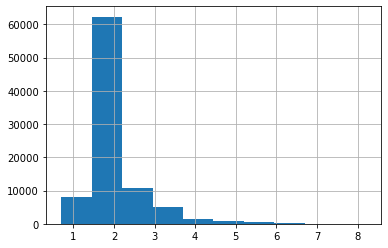

In [116]:
train['engineDisplacement'].hist(bins=10)

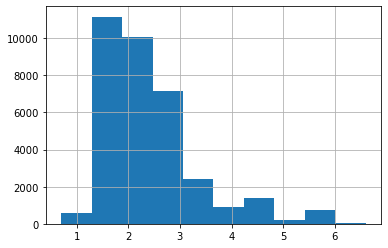

In [117]:
test['engineDisplacement'].hist(bins=10)

### 11. vehileTransmission

In [118]:
train.vehicleTransmission.value_counts()

AUTOMATIC     48963
MECHANICAL    25160
ROBOT          7838
VARIATOR       7006
Name: vehicleTransmission, dtype: int64

In [119]:
test.vehicleTransmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [120]:
train.vehicleTransmission.value_counts().index

Index(['AUTOMATIC', 'MECHANICAL', 'ROBOT', 'VARIATOR'], dtype='object')

In [121]:
test.vehicleTransmission.value_counts().index

Index(['автоматическая', 'механическая', 'вариатор', 'роботизированная'], dtype='object')

In [122]:
dic_trans={'AUTOMATIC':'автоматическая', 'MECHANICAL':'механическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'}
train['vehicleTransmission']=train['vehicleTransmission'].map(dic_trans)

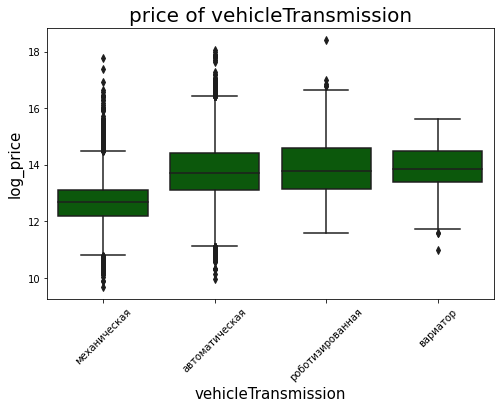

In [123]:
plot_my_boxplot(x='vehicleTransmission',y='log_price',title="price of vehicleTransmission")

самые дешвые машины на механике, робот и автомат примерно одинаков, вариаторов меньше и они чуть дешевле

### 12. vehileConfiguration

In [124]:
train.vehicleConfiguration.sample(5)

62491            LIFTBACK AUTOMATIC 1.8
18404              SEDAN MECHANICAL 1.5
31446               SEDAN AUTOMATIC M35
25709    ALLROAD_5_DOORS MECHANICAL 1.6
7059               SEDAN AUTOMATIC 530d
Name: vehicleConfiguration, dtype: object

In [125]:
test.vehicleConfiguration.sample(5)

14712    ALLROAD_5_DOORS AUTOMATIC 5.6
31439    ALLROAD_5_DOORS AUTOMATIC 2.5
28313    ALLROAD_5_DOORS AUTOMATIC 3.0
321       WAGON_5_DOORS MECHANICAL 1.4
18480      COUPE_HARDTOP AUTOMATIC 5.5
Name: vehicleConfiguration, dtype: object

в принципе  дублирует информацию. Удаляем

In [126]:
columns_drop="vehicleConfiguration"
train.drop(columns_drop, axis=1, inplace=True)
test.drop(columns_drop, axis=1, inplace=True)

### 13. numberOfDoors

In [127]:
test[test.numberOfDoors == 0] #.value_counts()

,brand,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,...,Владение,ПТС,Привод,Руль,bodyType2,bT_length,brand_length,log_power,Nalog_base,Nalog
16944,MERCEDES,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1904,SIMPLEX,...,6 лет и 8 месяцев,Оригинал,задний,Правый,другой,9,8,3.465736,12,384


In [128]:
train[train.numberOfDoors == 0]

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,description,...,start_date,model_name,vendor,bodyType2,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog
88065,MERCEDES,FAFBFB,бензин,1904,0,1904,механическая,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",...,2019-11-20T14:14:11Z,SIMPLEX,EUROPEAN,другой,16.300417,9,8,3.465736,12,384


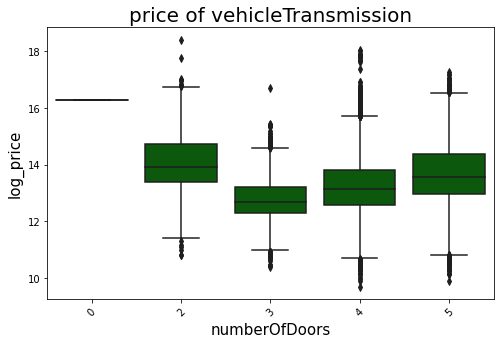

In [129]:
plot_my_boxplot(x='numberOfDoors',y='log_price',title="price of vehicleTransmission")

Раритетные машины без дверей очнь дорогие. Двухдверные машины идут следом.3 дверны самые дешевые и далее идт рост цены с увеличением количества дверей


### 14. color

In [130]:
train.color.value_counts()

040001    25094
FAFBFB    15761
CACECB    11282
97948F    10773
0000CC     8825
EE1D19     4489
200204     3562
007F00     2592
C49648     1841
22A0F8     1392
DEA522      771
660099      746
FFD600      699
4A2197      600
FF8649      515
FFC0CB       25
Name: color, dtype: int64

In [131]:
test.color.value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

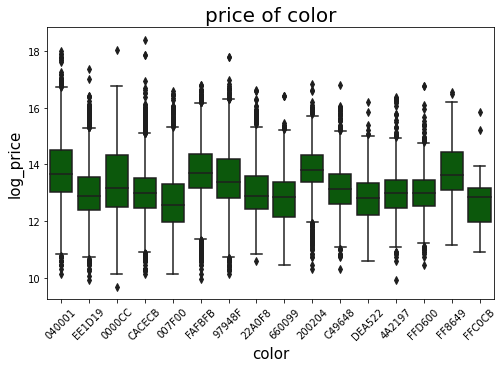

In [132]:
plot_my_boxplot(x='color',y='log_price',title="price of color")

В зависимости от цвета имеется изменение цены. Хотя и черные машины есть как дорогие, так и дешевые

Нужно привести данные к одинаковым значениям, конечно цифровые более точные, но текст более понятен.
не все цвета "точно" соответствуют номерам, но не будем увеличивать выборку

In [133]:
dic_color={'040001':'чёрный',
 'FAFBFB':'белый',
 'CACECB':'серебристый',
 '97948F':'серый',
 '0000CC':'синий',
 'EE1D19':'красный',
 '200204':'коричневый',
 '007F00':'зелёный',
 'C49648':'бежевый',
 '22A0F8':'голубой',
 'DEA522':'золотистый',
 '660099':'пурпурный',
 'FFD600':'жёлтый',
 '4A2197':'фиолетовый',
 'FF8649':'оранжевый',
 'FFC0CB':'розовый'}

In [134]:
train["color"]=train["color"].map(dic_color)

### 15. productionDate 

In [135]:
train['years_old'] = 2021 - train['productionDate']
test['years_old'] = 2021 - test['productionDate']

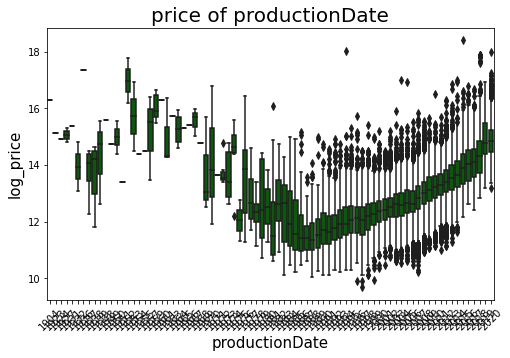

In [136]:
plot_my_boxplot(x='productionDate',y='log_price',title="price of productionDate")

In [137]:
train[train.productionDate < 1940].sample(5)

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,description,...,model_name,vendor,bodyType2,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog,years_old
303,AUDI,чёрный,бензин,1938,4,1938,механическая,3.3,75,"Ауди кабриолет, 1938 г., ретро, на ходу, есть ...",...,920,EUROPEAN,седан,14.508657,5,4,4.317488,12,900,83
61846,SKODA,чёрный,бензин,1934,3,1939,механическая,1.1,30,"Авто после длительного простоя, под восстановл...",...,POPULAR,EUROPEAN,хэтчбек 3 дв.,12.611538,13,5,3.401197,12,360,82
22689,other,синий,бензин,1927,3,1927,механическая,3.3,40,Машина растаможена в лоб\nНалог низкий\nМотор ...,...,MODEL_A,other,хэтчбек 3 дв.,15.319588,13,5,3.688879,12,480,94
22692,other,чёрный,бензин,1908,2,1924,механическая,2.9,20,"Главный автомобиль XX века, без которого, наве...",...,MODEL_T,other,другой,14.914123,9,5,2.995732,12,240,97
22688,other,пурпурный,бензин,1927,3,1931,механическая,3.3,40,"1931 fofd model T, 400hp, automatic transmisio...",...,MODEL_A,other,хэтчбек 3 дв.,15.363884,13,5,3.688879,12,480,90


Раритетные машины, поэтому не изменяем нижнюю границу

In [138]:
train.years_old.value_counts().head(10)

1     12503
13     7013
9      6603
10     6151
8      5580
14     5397
7      4524
11     4456
15     3613
6      3127
Name: years_old, dtype: int64

Больше всего машин новых или, которым 6-14 лет

In [139]:
train.years_old.describe()

count    88967.000000
mean        10.165050
std          7.027762
min          1.000000
25%          5.000000
50%         10.000000
75%         14.000000
max        117.000000
Name: years_old, dtype: float64

In [140]:
test.years_old.describe()

count    34686.000000
mean        11.735398
std          7.047661
min          1.000000
25%          7.000000
50%         10.000000
75%         15.000000
max        117.000000
Name: years_old, dtype: float64

In [141]:
train[train.years_old == 117]

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,description,...,model_name,vendor,bodyType2,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog,years_old
88065,MERCEDES,белый,бензин,1904,0,1904,механическая,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",...,SIMPLEX,EUROPEAN,другой,16.300417,9,8,3.465736,12,384,117


In [142]:
# Разобьем возраст автомобилей на интервалы
bins = [-1, 3, 6, 13, 20, 35, 117]
numbers = [3, 6,13,20,35, 117]

train['age_intervals']=pd.cut(train['years_old'],bins,labels=numbers)
test['age_intervals']=pd.cut(test['years_old'],bins,labels=numbers)

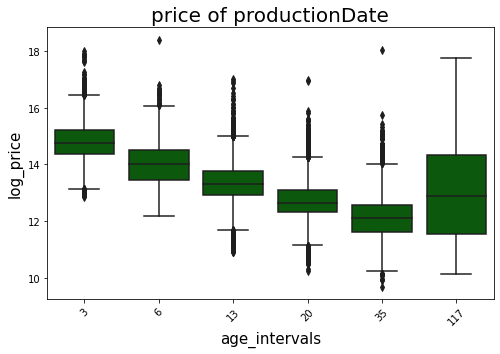

In [143]:
plot_my_boxplot(x='age_intervals',y='log_price',title="price of productionDate")

C увеличение возраста падает цена машины, и только раритетные составляют исключение

### 16. modelDate

In [144]:
train.modelDate.describe()

count    88967.000000
mean      2008.545067
std          7.419210
min       1904.000000
25%       2005.000000
50%       2009.000000
75%       2014.000000
max       2020.000000
Name: modelDate, dtype: float64

In [145]:
test.modelDate.describe()

count    34686.000000
mean      2007.074728
std          7.415894
min       1904.000000
25%       2004.000000
50%       2008.000000
75%       2012.000000
max       2020.000000
Name: modelDate, dtype: float64

In [146]:
train.modelDate.value_counts().head(15)

2006    6112
2010    5875
2009    5679
2017    5618
2018    5196
2011    4736
2005    4690
2012    4481
2007    4129
2008    4050
2014    3539
2015    3517
2016    3276
2002    3271
2013    3253
Name: modelDate, dtype: int64

In [147]:
check_na("modelDate")

col = modelDate;
isna_train = 0
isna_test = 0


Логично, что более старых машин выпущено больше

### 17. Владельцы

In [148]:
check_na("Владельцы")

col = Владельцы;
isna_train = 0
isna_test = 0


In [149]:
test.Владельцы.value_counts()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [150]:
test.Владельцы = test.Владельцы.apply(lambda x: x[0])

In [151]:
train.Владельцы.value_counts()

 3                      36098
 2                      20902
 1                      18398
-9223372036854775808    13569
Name: Владельцы, dtype: int64

In [152]:
train.Владельцы = train.Владельцы.apply(lambda x: 3 if x<1 else x)

In [153]:
train.Владельцы = train.Владельцы.values.astype('int64')
test.Владельцы = test.Владельцы.values.astype('int64')

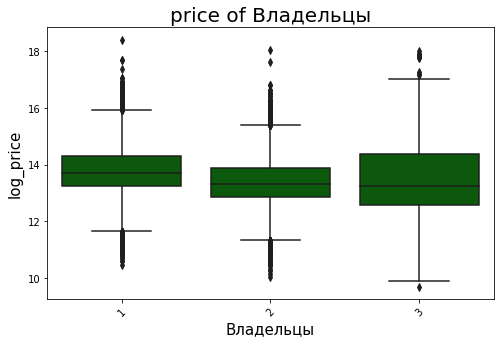

In [154]:
plot_my_boxplot(x='Владельцы',y='log_price',title="price of Владельцы")

наблюдается тенденция на уменьшение стоимости с увеличением количества владельцев. Чем новее машина, тем меньше у нее владельцв

### 18. Владение

In [155]:
# Данных признак содержит много пропущенных значений
check_na("Владение")

col = Владение;
isna_train = 59922
isna_test = 22691


In [156]:
train.Владение.sample(10)

18139                            NaN
38065                            NaN
85248                            NaN
10301                            NaN
49775                            NaN
30721                            NaN
82034                            NaN
83043    {'year': 2017, 'month': 10}
36875    {'year': 2015, 'month': 11}
76348                            NaN
Name: Владение, dtype: object

In [157]:
train.groupby('Владельцы').Владение.describe()

,count,unique,top,freq
Владельцы,,,,
1,7497,246,"{'year': 2018, 'month': 12}",109
2,8220,248,"{'year': 2018, 'month': 8}",148
3,13328,243,"{'year': 2019, 'month': 8}",300


С увеличением количества владельцев владением уменьшается. Есть потенциал у признака. Но пока удалим его, так как частично информация дублируется и больше половины пропущенных значений в обоих данных.

In [158]:
columns_drop = ['Владение']
train.drop(columns_drop, axis=1, inplace=True)
test.drop(columns_drop, axis=1, inplace=True)

### 19. Руль

In [159]:
check_na("Руль")

col = Руль;
isna_train = 0
isna_test = 0


In [160]:
train.Руль.value_counts()

LEFT     87185
RIGHT     1782
Name: Руль, dtype: int64

In [161]:
test.Руль.value_counts()

Левый     33287
Правый     1399
Name: Руль, dtype: int64

In [162]:
dict_swheel={"LEFT":"Левый","RIGHT":"Правый"}
train.Руль=train.Руль.map(dict_swheel)

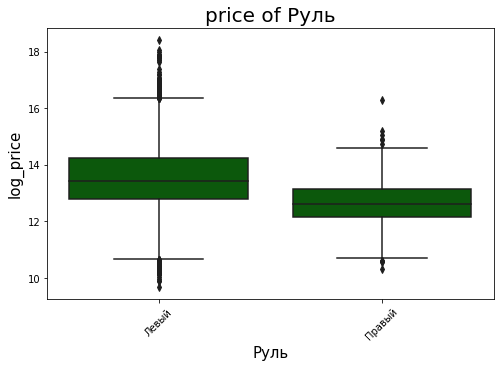

In [163]:
plot_my_boxplot(x='Руль',y='log_price',title="price of Руль")

праворуких машин меньше и стоят они дешевле

### 20. ПТС

In [164]:
check_na("ПТС")

col = ПТС;
isna_train = 0
isna_test = 0


In [165]:
train.ПТС.value_counts()

ORIGINAL     78230
DUPLICATE    10376
Оригинал       361
Name: ПТС, dtype: int64

In [166]:
dict_swheel={"ORIGINAL":"Оригинал","DUPLICATE":"Дубликат","Оригинал":"Оригинал"}
train.ПТС=train.ПТС.map(dict_swheel)

In [167]:
test.ПТС.value_counts()

Оригинал    30099
Дубликат     4587
Name: ПТС, dtype: int64

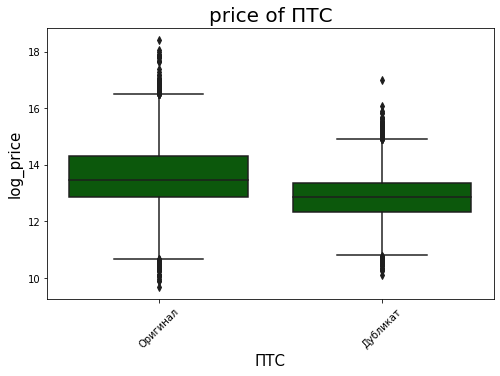

In [168]:
plot_my_boxplot(x='ПТС',y='log_price',title="price of ПТС")

Большая часть машин с оригинальным птс и стоят они дороже

### 21. sell_id

In [169]:
test.sell_id.nunique()

34686

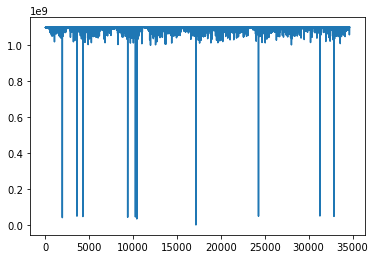

In [170]:
test['sell_id'].plot()

id объявления о продаже содержит уникальных значений сколько и объявлений. Можно удалить.

In [171]:
columns_drop = ['sell_id']
test.drop(columns_drop, axis=1, inplace=True)

### 22. image

In [172]:
test.image[1]

'https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7CxRKU17ysuJYxu9kY0fj5q5NROmsLgu7CQ34WY0UI0pVdyN6pahANodRBrYA5TJ-4z2K9_O-mo6XT34oWVQDBTEybGZikaX4X4bwLyUujf_KICqw3ygs2UNJlXu4Og#DSD'

Обрабатывать картинки я не умею. Удаляю признак

In [173]:
columns_drop = ['image']
test.drop(columns_drop, axis=1, inplace=True)

### 23. description

In [174]:
train.description[1]

'Машина в оригинале не гнилая все вопросы по телефону. Птс оригинал, двигатель 1.8 90 л/с, карбюратор родной двигатель масло не ест. '

In [175]:
train.description = train.description.apply(lambda x: str(x).lower())
test.description = test.description.apply(lambda x: str(x).lower())

Посмотрим что часто пишут в объявлениях и построим облако слов

In [176]:
text = ' '.join(train['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(30)
my_list

[(('', '', '', '', ''), 33650),
 (('-', '-', '-', '-', '-'), 10200),
 (('подушки', 'безопасности', 'водителя\n•', 'подушки', 'безопасности'), 6482),
 (('иммобилайзер\n•', 'центральный', 'замок\n•', 'бортовой', 'компьютер\n•'),
  6338),
 (('крепления', 'детских', 'автокресел', 'isofix', '/'), 6258),
 (('система', 'крепления', 'детских', 'автокресел', 'isofix'), 6235),
 (('детских', 'автокресел', 'isofix', '/', 'latch\n•'), 6231),
 (('боковые', 'зеркала', 'заднего', 'вида', 'с'), 5752),
 (('центральный', 'замок\n•', 'бортовой', 'компьютер\n•', 'круиз-контроль\n•'),
  5613),
 (('безопасности', 'водителя\n•', 'подушки', 'безопасности', 'пассажира\n•'),
  5125),
 (('литые', 'легкосплавные', 'диски\n•', 'размер', 'дисков'), 4930),
 (('безопасности\n•', 'система', 'крепления', 'детских', 'автокресел'), 4865),
 (('подогрев', 'сидений', 'водителя', 'и', 'пассажира\n•'), 4854),
 (('количество', 'мест:', '5\n•', 'тип', 'сидений:'), 4723),
 (('система', 'помощи', 'при', 'старте', 'в'), 4669),
 (('

И для тестовой выборки

In [177]:
text = ' '.join(test['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(30)
my_list

[(('', '', '', '', ''), 19450),
 (('иммобилайзер\n•', 'центральный', 'замок\n•', 'бортовой', 'компьютер\n•'),
  1059),
 (('электростеклоподъемники', 'передние', 'и', 'задние\n•', 'электропривод'),
  1025),
 (('передние', 'и', 'задние\n•', 'электропривод', 'зеркал\n•'), 1023),
 (('обмен', 'вашего', 'автомобиля', 'на', 'новый'), 983),
 (('крепления', 'детских', 'автокресел', 'isofix', '/'), 976),
 (('-', 'обмен', 'вашего', 'автомобиля', 'на'), 972),
 (('вашего', 'автомобиля', 'на', 'новый', 'или'), 972),
 (('автомобиля', 'на', 'новый', 'или', 'с'), 972),
 (('подогрев', 'сидений', 'водителя', 'и', 'пассажира\n•'), 972),
 (('система', 'крепления', 'детских', 'автокресел', 'isofix'), 970),
 (('детских', 'автокресел', 'isofix', '/', 'latch\n•'), 969),
 (('подушки', 'безопасности', 'водителя\n•', 'подушки', 'безопасности'), 961),
 (('юридической', 'чистоты', 'в', 'соответствии', 'с'), 957),
 (('центральный', 'замок\n•', 'бортовой', 'компьютер\n•', 'круиз-контроль\n•'),
  938),
 (('безопасност

In [178]:
def my_wordcloud(textdata = test.description, newStopWords = ['автомобиль', 'продаю', 'автомобилей', 'пробег']):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    stopwords.update(newStopWords)


    # iterate through the csv file 
    for val in textdata: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=200, 
        width=1000, height=800,
        random_state=42,
    ).generate(" ".join(test['description'].astype(str)))

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 14), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

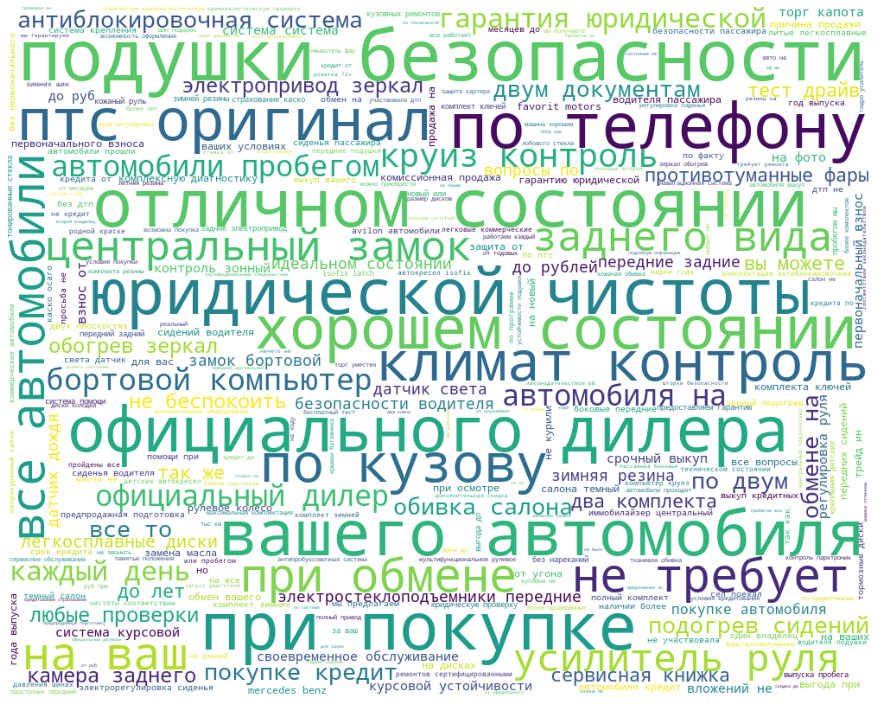

In [179]:
my_wordcloud(textdata = test.description, newStopWords = ['автомобиль', 'продаю', 'автомобилей', 'пробег'])

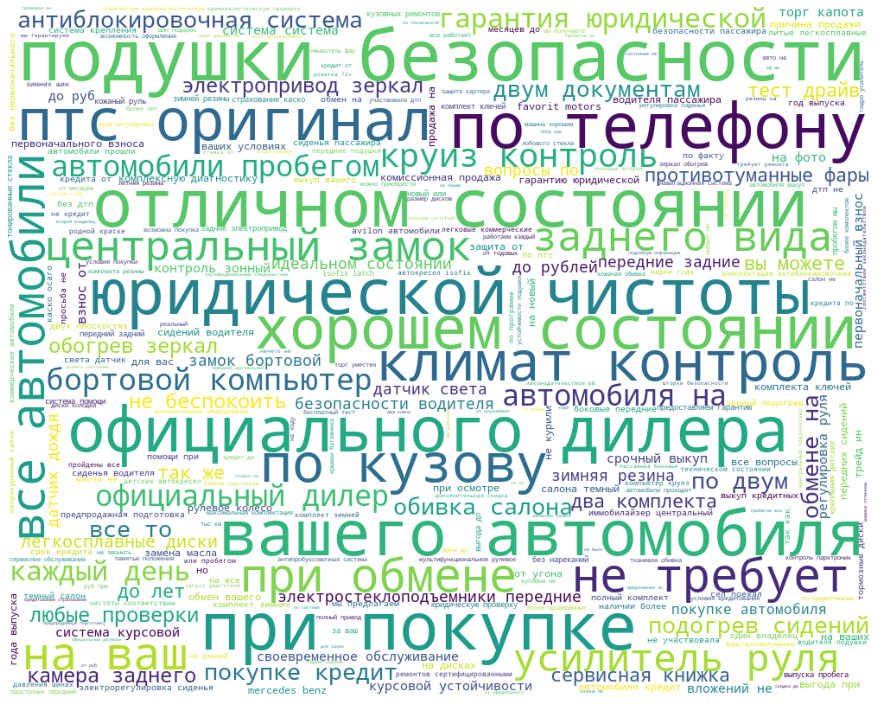

In [180]:
my_wordcloud(textdata = train.description, newStopWords = ['автомобиль', 'продаю', 'автомобилей', 'пробег'])

In [181]:
def new_col_1(col,text):
    train[col] = train.description.apply(lambda x: 1 if text in x else 0)
    test[col] = test.description.apply(lambda x: 1 if text in x else 0)  

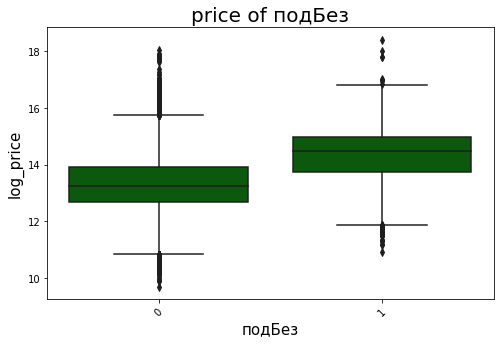

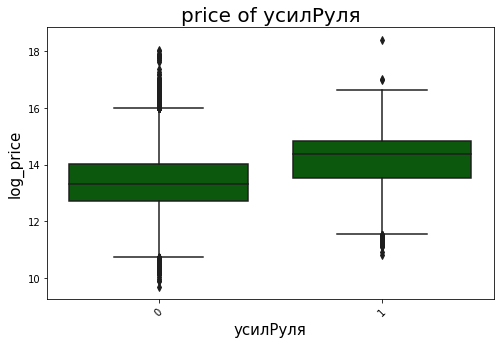

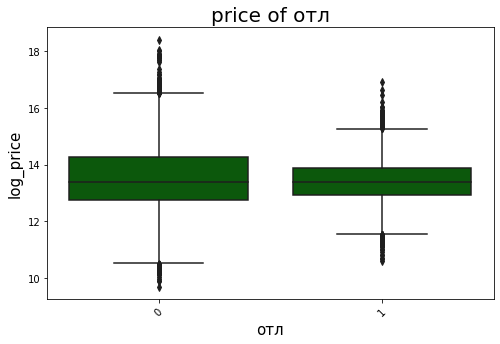

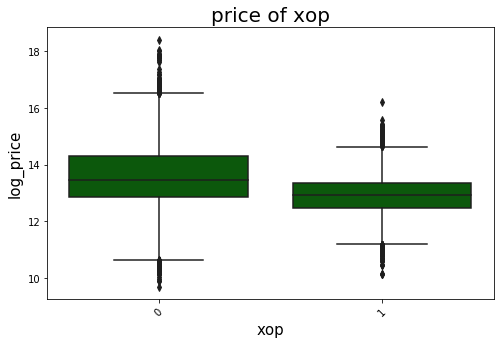

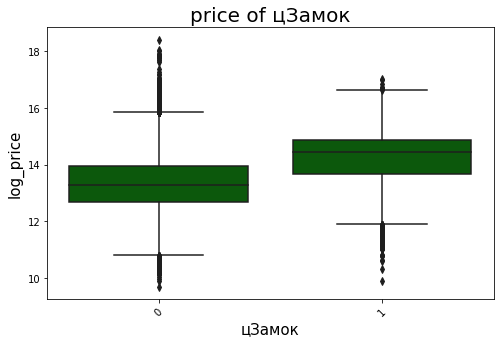

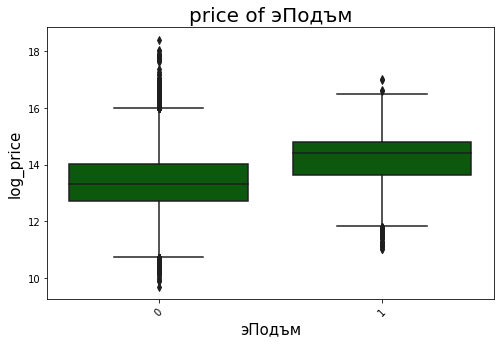

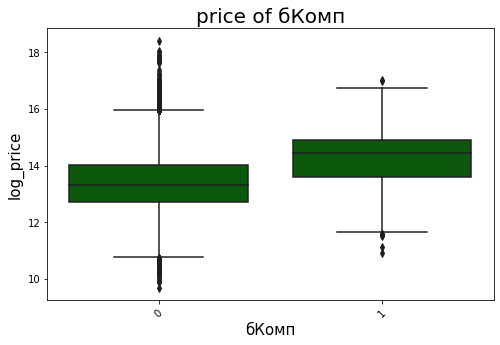

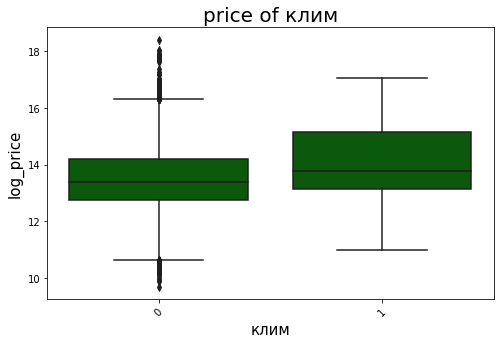

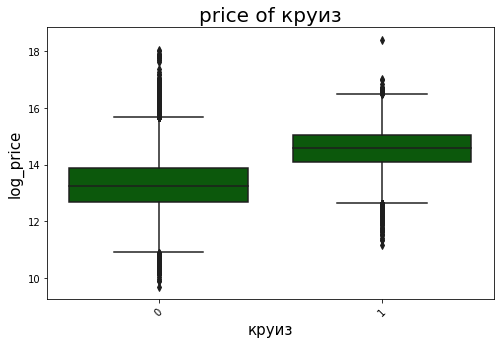

In [182]:
cols = {'подБез':'подушки безопасности',
        'усилРуля':'усилитель руля',
       'отл':'отличном состоянии',
       'хор':'хорошем состоянии',
       'цЗамок':'центральный замок',
       'эПодъм':'электростеклоподъемники',
       'бКомп':'бортовой компьютер',
       'клим':'климат контроль',
       "круиз":"круиз"}
for col in cols:
    #display(col,cols[col])
    new_col_1(col,cols[col])
    plot_my_boxplot(x=col,y='log_price',title="price of "+col)

В целом чуть дороже машины, у которых в описании есть подушки безопасности, усилитель руля, бортовой компьютер, электростеклоподъемники, климат контроль, круиз и центральный замок. Те, кто пишут в хорошем состоянии - машины дешевле чем если это не указано. А вот в отличном состоянии видно указывают независимо от состояния.

In [183]:
columns_drop = ['отл']
test.drop(columns_drop, axis=1, inplace=True)
train.drop(columns_drop, axis=1, inplace=True)

In [184]:
columns_drop = ['description']
test.drop(columns_drop, axis=1, inplace=True)
train.drop(columns_drop, axis=1, inplace=True)

### 24. fuelType

In [185]:
test.fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

In [186]:
train.fuelType.value_counts()

бензин     74710
дизель     13841
гибрид       294
электро      111
газ           11
Name: fuelType, dtype: int64

In [187]:
check_na("fuelType")

col = fuelType;
isna_train = 0
isna_test = 0


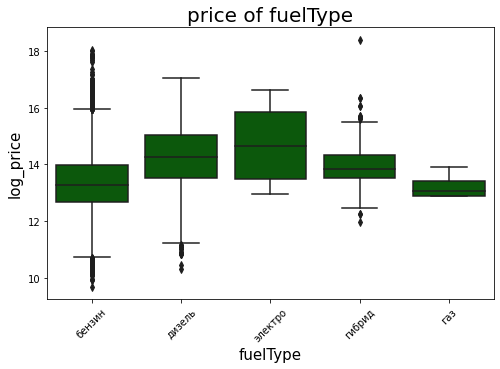

In [188]:
plot_my_boxplot(x="fuelType",y='log_price',title="price of fuelType")

### 25. parsing_unixtime

In [189]:
test.parsing_unixtime.sample(5)

4754     1603130871
16954    1603245879
4183     1603128692
26180    1603224174
19438    1603287918
Name: parsing_unixtime, dtype: int64

In [190]:
columns_drop = ['parsing_unixtime']
test.drop(columns_drop, axis=1, inplace=True)
#train.drop(columns_drop, axis=1, inplace=True)

### 26. super_gen

In [191]:
test.super_gen[2]

'{"id":"20026323","nameplate":"DSG","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":152,"power_kvt":112,"human_name":"DSG 1.8 AMT (152 л.с.)","acceleration":8.7,"clearance_min":139,"fuel_rate":7.1,"clearance_max":158}'

In [192]:
train.columns

Index(['brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'engineDisplacement',
       'enginePower', 'mileage', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'price',
       'start_date', 'model_name', 'vendor', 'bodyType2', 'log_price',
       'bT_length', 'brand_length', 'log_power', 'Nalog_base', 'Nalog',
       'years_old', 'age_intervals', 'подБез', 'усилРуля', 'хор', 'цЗамок',
       'эПодъм', 'бКомп', 'клим', 'круиз'],
      dtype='object')

К сожалению данного признака нет в трейне. Неплохая категория. Удаляем признак

In [193]:
columns_drop = ['super_gen']
test.drop(columns_drop, axis=1, inplace=True)
#train.drop(columns_drop, axis=1, inplace=True)

### 27. vendor

In [194]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [195]:
train.vendor.value_counts()

EUROPEAN    42895
other       24263
JAPANESE    21809
Name: vendor, dtype: int64

In [196]:
check_na("vendor")

col = vendor;
isna_train = 0
isna_test = 0


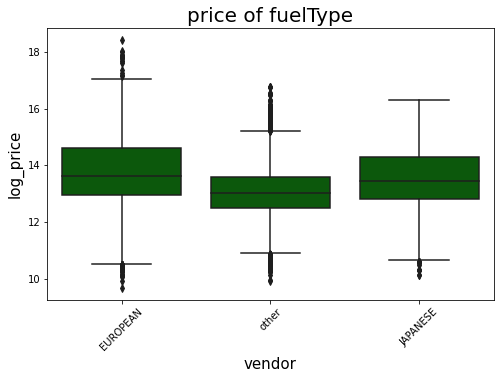

In [197]:
plot_my_boxplot(x="vendor",y='log_price',title="price of fuelType")

Производитель не сильно влияет в целом, хотя европейские машины более дорогие

### 28. mileage

In [198]:
check_na("mileage")

col = mileage;
isna_train = 0
isna_test = 0


In [199]:
train.mileage.describe()

count      88967.000000
mean      134826.642991
std       103020.880462
min            0.000000
25%        56000.000000
50%       130000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [200]:
train[train.mileage == 0].groupby('years_old').price.describe()

,count,mean,std,min,25%,50%,75%,max
years_old,,,,,,,,
1,12247.0,3498984.25,2557871.25,645000.0,1910500.0,2776200.0,4094750.0,65435792.0
2,1233.0,5251843.50,3879735.75,871900.0,2337000.0,3414800.0,7942000.0,18712930.0
3,88.0,10405351.00,14908002.00,899900.0,5741750.0,6576271.0,6663363.0,59087576.0
4,1.0,3829900.00,NaN,3829900.0,3829900.0,3829900.0,3829900.0,3829900.0


In [201]:
train.groupby('years_old').mileage.mean().head(10)

years_old
1         47.451412
2      12220.139804
3      43177.718212
4      66816.090090
5      87288.886667
6     100090.878478
7     114924.231874
8     125625.213262
9     135842.210813
10    145858.976101
Name: mileage, dtype: float64

В среднем за первый год машина проходит до 10 000 км, а после по 20000

In [202]:
#train['mileageNAN'] = train.mileageNAN * (train.years_old * 20000 + 10000)

In [203]:
#train.mileage = train.mileage + train.mileageNAN

In [204]:
train.mileage.describe()

count      88967.000000
mean      134826.642991
std       103020.880462
min            0.000000
25%        56000.000000
50%       130000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [205]:
train[train.mileage == 1].productionDate

18051    2005
24788    2019
24789    2019
42002    2019
53666    1996
59535    2014
83747    2020
83820    2020
85056    2020
86843    2020
88166    2020
88167    2020
88210    2020
88213    2020
88289    2020
88290    2020
88291    2019
88304    2020
88305    2020
88440    2008
88652    1936
Name: productionDate, dtype: int64

Даже у новых машин 1 км это мало. заменим на 1000

In [206]:
train['mileage'] = train['mileage'].apply(lambda x: 1000 if x <1000 else x)
test['mileage'] = test['mileage'].apply(lambda x: 1000 if x < 1000 else x)

In [207]:
train.mileage.describe()

count      88967.000000
mean      134982.700024
std       102817.081500
min         1000.000000
25%        56000.000000
50%       130000.000000
75%       195000.000000
max      1000000.000000
Name: mileage, dtype: float64

### 29. Привод

In [208]:
check_na("Привод")

col = Привод;
isna_train = 0
isna_test = 0


In [209]:
train.Привод.value_counts()

передний    47088
полный      34845
задний       7034
Name: Привод, dtype: int64

In [210]:
test.Привод.value_counts()

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

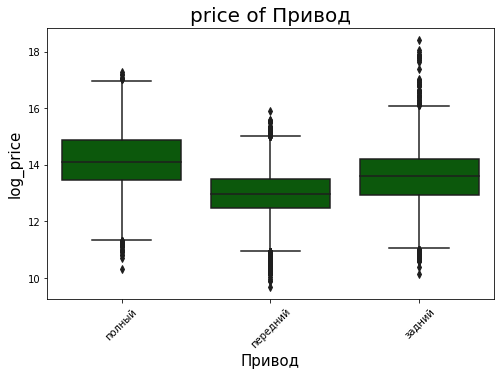

In [211]:
plot_my_boxplot(x="Привод",y='log_price',title="price of Привод")

Полный самый дорогой, а передний - самый дешевый.

### Целевая переменная price

In [212]:
train.price.describe()

count    8.896700e+04
mean     1.294593e+06
std      1.950391e+06
min      1.600000e+04
25%      3.500000e+05
50%      6.500000e+05
75%      1.480000e+06
max      9.900000e+07
Name: price, dtype: float64

In [213]:
train[train.price > 30000000]

,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,...,years_old,age_intervals,подБез,усилРуля,хор,цЗамок,эПодъм,бКомп,клим,круиз
56585,other,серебристый,гибрид,2013,2,2015,роботизированная,4.6,608,5169,...,6,6,1,1,0,0,0,0,0,1
83976,MERCEDES,чёрный,бензин,2018,5,2020,автоматическая,1.8,800,1000,...,1,3,0,0,0,0,0,0,0,0
86874,MERCEDES,чёрный,бензин,2017,4,2020,автоматическая,1.8,630,1000,...,1,3,1,0,0,0,0,0,0,0
86877,MERCEDES,серебристый,бензин,2017,4,2018,автоматическая,1.8,630,1000,...,3,3,0,0,0,0,0,0,0,0
86878,MERCEDES,чёрный,бензин,2017,4,2018,автоматическая,1.8,630,1000,...,3,3,0,0,0,0,0,0,0,0
86879,MERCEDES,чёрный,бензин,2017,4,2018,автоматическая,1.8,530,2527,...,3,3,0,0,0,0,0,0,0,0
86881,MERCEDES,серый,бензин,2017,4,2018,автоматическая,1.8,630,1000,...,3,3,0,0,0,0,0,0,0,0
86882,MERCEDES,чёрный,бензин,2017,4,2018,автоматическая,1.8,630,1000,...,3,3,0,0,0,0,0,0,0,0
86884,MERCEDES,чёрный,бензин,2017,4,2018,автоматическая,1.8,530,2527,...,3,3,0,0,0,0,0,0,0,0
86885,MERCEDES,чёрный,бензин,2017,4,2018,автоматическая,1.8,530,1000,...,3,3,1,0,0,0,0,0,0,0


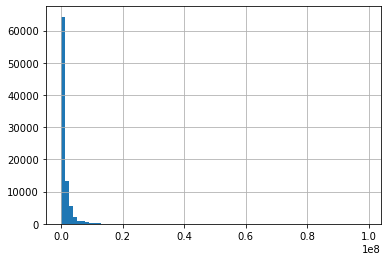

In [214]:
train['price'].hist(bins=77)

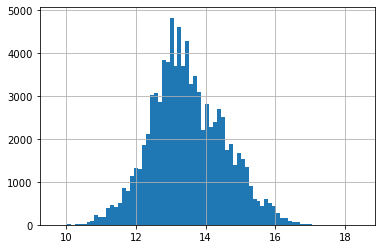

In [215]:
train['log_price'].hist(bins=77)

Логарифмирование привело к нормальному распределению

## Удалим признаки, которые не нужны

In [216]:
train.columns

Index(['brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'engineDisplacement',
       'enginePower', 'mileage', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'price',
       'start_date', 'model_name', 'vendor', 'bodyType2', 'log_price',
       'bT_length', 'brand_length', 'log_power', 'Nalog_base', 'Nalog',
       'years_old', 'age_intervals', 'подБез', 'усилРуля', 'хор', 'цЗамок',
       'эПодъм', 'бКомп', 'клим', 'круиз'],
      dtype='object')

In [217]:
train.sample(1).transpose()

,49792
brand,NISSAN
color,белый
fuelType,бензин
modelDate,2011
numberOfDoors,4
productionDate,2012
vehicleTransmission,вариатор
engineDisplacement,2.5
enginePower,182
mileage,91500


In [218]:
test.columns

Index(['brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate',
       'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'bodyType2', 'bT_length', 'brand_length', 'log_power', 'Nalog_base',
       'Nalog', 'years_old', 'age_intervals', 'подБез', 'усилРуля', 'хор',
       'цЗамок', 'эПодъм', 'бКомп', 'клим', 'круиз'],
      dtype='object')

In [219]:
test.sample(1).transpose()

,24090
brand,VOLKSWAGEN
color,чёрный
engineDisplacement,1.8
enginePower,152
fuelType,бензин
mileage,140000
modelDate,2011
model_name,PASSAT
numberOfDoors,4
productionDate,2013


In [220]:
train.drop('start_date', axis=1, inplace=True)

In [221]:
set(train.columns)-set(test.columns)


{'log_price', 'price'}

In [222]:
set(test.columns)-set(train.columns)

set()

In [223]:
columns_drop = ['log_power']
train.drop(columns_drop, axis=1, inplace=True)
test.drop(columns_drop, axis=1, inplace=True)

## Создадим полиномиальные признаки

In [224]:
pf = PolynomialFeatures(2)
features = ['Владельцы','engineDisplacement', 'enginePower',
       'modelDate', 'numberOfDoors', 'productionDate', 
       'bT_length', 'brand_length', 'Nalog_base', 'Nalog', 'years_old',
       'age_intervals', 'подБез', 'усилРуля', 'хор', 'цЗамок', 'эПодъм', 'бКомп', 'клим', 'круиз']
poly_df = pf.fit_transform(train[features])
poly_df1 = pd.DataFrame(poly_df)
poly_df1 = poly_df1.drop(0, axis=1)

In [225]:
poly_df1['log_price'] = np.log(train.price)
poly_df1

,1,2,3,4,5,6,7,8,9,10,...,222,223,224,225,226,227,228,229,230,log_price
0,3.0,2.8,174.0,1990.0,4.0,1991.0,5.0,4.0,45.0,7830.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.206073
1,3.0,1.8,90.0,1982.0,4.0,1986.0,5.0,4.0,12.0,1080.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.002100
2,3.0,2.3,136.0,1988.0,5.0,1989.0,15.0,4.0,35.0,4760.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.502875
3,3.0,1.8,90.0,1988.0,4.0,1989.0,5.0,4.0,12.0,1080.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.082143
4,3.0,2.0,101.0,1990.0,4.0,1991.0,5.0,4.0,25.0,2525.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.512925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88962,3.0,2.7,163.0,2004.0,5.0,2006.0,7.0,5.0,45.0,7335.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.270783
88963,3.0,2.7,163.0,2004.0,5.0,2007.0,7.0,5.0,45.0,7335.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.043553
88964,1.0,2.0,149.0,2013.0,5.0,2014.0,7.0,5.0,35.0,5215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.254863
88965,3.0,2.0,149.0,2013.0,5.0,2013.0,7.0,5.0,35.0,5215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.409014


In [226]:
poly_df2 = pf.fit_transform(test[features])
poly_df21 = pd.DataFrame(poly_df2)
poly_df21 = poly_df21.drop(0, axis=1)

## Корреляция

In [227]:
poly_df1.corr()['log_price'].sort_values().tail(10)

64           0.361222
9            0.363624
114          0.364247
83           0.364290
99           0.371202
3            0.381483
63           0.382140
61           0.382203
62           0.389922
log_price    1.000000
Name: log_price, dtype: float64

In [228]:
poly_df1.corr()['log_price'].sort_values().head(10)

116   -0.173965
85    -0.173871
11    -0.172970
101   -0.166515
31    -0.150469
117   -0.137250
86    -0.137195
12    -0.136209
102   -0.134672
32    -0.120762
Name: log_price, dtype: float64

Посмотрим корреляцию числовых признаков к целевой переменной

Можно конечно некоторые оставить, но впервый раз попробуем без них

In [229]:
train.describe()

,modelDate,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,Владельцы,price,log_price,bT_length,...,Nalog,years_old,подБез,усилРуля,хор,цЗамок,эПодъм,бКомп,клим,круиз
count,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,8.896700e+04,88967.000000,88967.000000,...,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000,88967.000000
mean,2008.545067,4.510257,2010.834950,1.995523,171.241089,134982.700024,2.351467,1.294593e+06,13.487549,11.368552,...,11635.417863,10.165050,0.159745,0.120831,0.105421,0.151258,0.115773,0.116583,0.020255,0.148212
std,7.419210,0.653383,7.027762,0.667987,83.509899,102817.081500,0.800960,1.950391e+06,1.051161,5.540107,...,16041.229875,7.027762,0.366371,0.325933,0.307097,0.358303,0.319955,0.320924,0.140871,0.355312
min,1904.000000,0.000000,1904.000000,0.700000,11.000000,1000.000000,1.000000,1.600000e+04,9.680344,4.000000,...,132.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,4.000000,2007.000000,1.600000,115.000000,56000.000000,2.000000,3.500000e+05,12.765689,5.000000,...,2875.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2009.000000,5.000000,2011.000000,1.800000,150.000000,130000.000000,3.000000,6.500000e+05,13.384727,13.000000,...,5250.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,5.000000,2016.000000,2.000000,199.000000,195000.000000,3.000000,1.480000e+06,14.207553,17.000000,...,9950.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,5.000000,2020.000000,8.200000,800.000000,1000000.000000,3.000000,9.900000e+07,18.410631,37.000000,...,120000.000000,117.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [230]:
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'bT_length', 'Nalog_base',
       'brand_length', 'Nalog', 'years_old', 'log_price']

In [231]:
correlation = train[num_cols].corr()
correlation

,engineDisplacement,enginePower,mileage,bT_length,Nalog_base,brand_length,Nalog,years_old,log_price
engineDisplacement,1.000000,0.467963,0.088227,0.225311,0.465662,-0.016196,0.406018,0.085714,0.219244
enginePower,0.467963,1.000000,-0.168101,0.203783,0.922090,-0.025012,0.954337,-0.191181,0.601782
mileage,0.088227,-0.168101,1.000000,-0.174133,-0.109317,-0.001952,-0.122084,0.732409,-0.651223
bT_length,0.225311,0.203783,-0.174133,1.000000,0.197079,0.017758,0.170455,-0.183272,0.305837
Nalog_base,0.465662,0.922090,-0.109317,0.197079,1.000000,-0.026066,0.951869,-0.126181,0.517191
brand_length,-0.016196,-0.025012,-0.001952,0.017758,-0.026066,1.000000,-0.019659,0.001095,0.051260
Nalog,0.406018,0.954337,-0.122084,0.170455,0.951869,-0.019659,1.000000,-0.121822,0.488857
years_old,0.085714,-0.191181,0.732409,-0.183272,-0.126181,0.001095,-0.121822,1.000000,-0.726302
log_price,0.219244,0.601782,-0.651223,0.305837,0.517191,0.051260,0.488857,-0.726302,1.000000


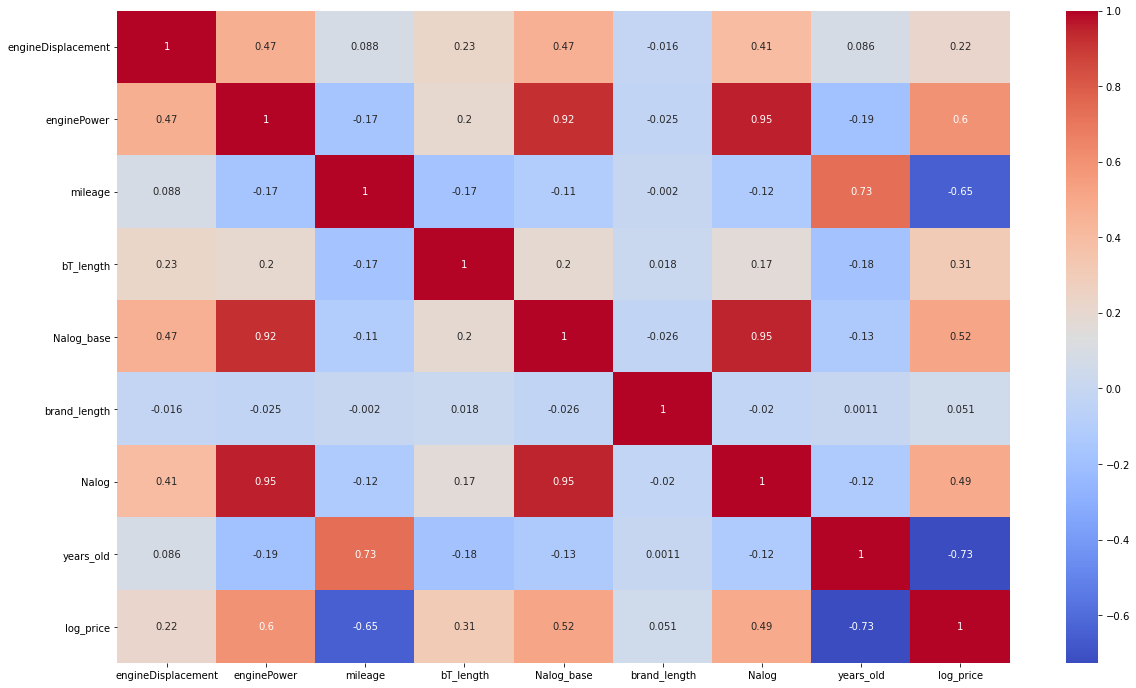

In [232]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Логарифм цены обратно коррелирует с возрастом машины и пробегом, и коррелирует с мощностью, объемом двигателя и налогом.
Длину бренда удалим - незначимый признак

In [233]:
columns_d = ['brand_length']
train.drop(columns_d, axis=1, inplace=True)
test.drop(columns_d, axis=1, inplace=True)

## Корреляция Спирмена для ранговых

In [234]:
train[['numberOfDoors', 'Владельцы']].corr(method='spearman')

,numberOfDoors,Владельцы
numberOfDoors,1.000000,-0.055679
Владельцы,-0.055679,1.000000


In [235]:
columns = ['brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
       'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'bodyType2', 'bT_length',
       'Nalog', 'years_old', 'age_intervals', 'подБез', 'усилРуля', 
       'хор', 'цЗамок', 'эПодъм', 'бКомп',
       'клим', 'круиз']

In [236]:
df_train = train[columns]
df_test = test[columns]
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
y = train['price']
y_log = train['log_price']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [237]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88967 entries, 0 to 89377
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   brand                88967 non-null  object  
 1   color                88967 non-null  object  
 2   engineDisplacement   88967 non-null  float32 
 3   enginePower          88967 non-null  int64   
 4   fuelType             88967 non-null  object  
 5   mileage              88967 non-null  int64   
 6   modelDate            88967 non-null  int64   
 7   model_name           88967 non-null  object  
 8   numberOfDoors        88967 non-null  int64   
 9   productionDate       88967 non-null  int64   
 10  vehicleTransmission  88967 non-null  object  
 11  vendor               88967 non-null  object  
 12  Владельцы            88967 non-null  int64   
 13  ПТС                  88967 non-null  object  
 14  Привод               88967 non-null  object  
 15  Руль               

In [238]:
train.sample(3).T

,80893,13573,60231
brand,MERCEDES,other,SKODA
color,белый,серый,синий
fuelType,бензин,бензин,бензин
modelDate,2018,2009,1998
numberOfDoors,5,4,5
productionDate,2020,2011,2000
vehicleTransmission,роботизированная,автоматическая,механическая
engineDisplacement,1.8,1.8,1.3
enginePower,136,141,68
mileage,1000,97000,280000


In [239]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   brand                34686 non-null  object  
 1   color                34686 non-null  object  
 2   engineDisplacement   34686 non-null  float32 
 3   enginePower          34686 non-null  int64   
 4   fuelType             34686 non-null  object  
 5   mileage              34686 non-null  int64   
 6   modelDate            34686 non-null  int64   
 7   model_name           34686 non-null  object  
 8   numberOfDoors        34686 non-null  int64   
 9   productionDate       34686 non-null  int64   
 10  vehicleTransmission  34686 non-null  object  
 11  vendor               34686 non-null  object  
 12  Владельцы            34686 non-null  int64   
 13  ПТС                  34686 non-null  object  
 14  Привод               34686 non-null  object  
 15  Руль               

In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123653 entries, 0 to 123652
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   brand                123653 non-null  object  
 1   color                123653 non-null  object  
 2   engineDisplacement   123653 non-null  float32 
 3   enginePower          123653 non-null  int64   
 4   fuelType             123653 non-null  object  
 5   mileage              123653 non-null  int64   
 6   modelDate            123653 non-null  int64   
 7   model_name           123653 non-null  object  
 8   numberOfDoors        123653 non-null  int64   
 9   productionDate       123653 non-null  int64   
 10  vehicleTransmission  123653 non-null  object  
 11  vendor               123653 non-null  object  
 12  Владельцы            123653 non-null  int64   
 13  ПТС                  123653 non-null  object  
 14  Привод               123653 non-null  object  
 15  

## Label Encoding

In [241]:
categories = ['bodyType2', 'brand', 'color',
              'fuelType', 'model_name', 'vendor',
              'Владельцы', 'vehicleTransmission',
              'Привод', 'age_intervals']
for column in categories:
    data[column] = data[column].astype('category').cat.codes

bin_cols = ['ПТС', 'Руль', 'подБез',
            'усилРуля', 'хор', 'цЗамок',
            'эПодъм','бКомп','клим', 'круиз']
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,...,age_intervals,подБез,усилРуля,хор,цЗамок,эПодъм,бКомп,клим,круиз,sample
0,8,13,1.2,105,0,74000,2013,684,5,2014,...,2,0,0,0,0,0,0,0,0,0
1,8,15,1.6,110,0,60563,2017,684,5,2017,...,1,1,1,0,1,0,1,0,1,0
2,8,12,1.8,152,0,88000,2013,919,5,2014,...,2,0,0,0,0,0,0,0,0,0
3,8,6,1.6,110,0,95000,2013,684,5,2014,...,2,0,0,0,0,0,0,0,0,0
4,8,1,1.8,152,0,58536,2008,684,5,2012,...,2,1,1,0,1,0,1,0,1,0


In [242]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

## Train Split

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1 : CatBoost

Точность модели 14.32 на Kaggle

LB 13.49410

In [245]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model1_catboost_v{VERSION}.csv', index=False)
sample_submission.head(10)

Точность модели на Кагле по метрике MAPE: 12.31%


,sell_id,price
0,1100575026,6.284682e+05
1,1100549428,8.754522e+05
2,1100658222,8.906696e+05
3,1100937408,6.635851e+05
4,1101037972,7.331802e+05
5,1100912634,7.129115e+05
6,1101228730,6.410033e+05
7,1100165896,3.970896e+05
8,1100768262,1.684085e+06
9,1101218501,8.502779e+05


# Model 2 : GradientBoostingRegressor

Точность модели на Кагле по метрике MAPE: 12.27%

LB 12.24281

In [246]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2_GradBosstReg_v{VERSION}.csv', index=False)
sample_submission.head(10)

Точность модели на Кагле по метрике MAPE: 12.28%


,sell_id,price
0,1100575026,6.066769e+05
1,1100549428,8.979619e+05
2,1100658222,8.880056e+05
3,1100937408,7.416547e+05
4,1101037972,7.579720e+05
5,1100912634,7.600018e+05
6,1101228730,5.774269e+05
7,1100165896,4.060501e+05
8,1100768262,1.986801e+06
9,1101218501,8.028093e+05


# Model 3 : RandomForestRegressor

Точность модели на Кагле по метрике MAPE: 13.45%

LB = 14.85384

In [247]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,) 
rfr.fit(X_train, np.log(y_train))

predict_test = np.exp(rfr.predict(X_test))
predict_submission = np.exp(rfr.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model3_randForReg_v{VERSION}.csv', index=False)
sample_submission.head(10)

KeyboardInterrupt: 

# 2 вариант анализа, исправим Label Encoding в onehotencoding

# Label Encoding 2

In [262]:
del df_train
del df_test
del data
del y
del y_log

In [263]:
df_train = train[columns]
df_test = test[columns]
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
y = train['price']
y_log = train['log_price']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [264]:
from sklearn.preprocessing import OneHotEncoder

In [265]:
# в первом варианте все значения "категориальные" были переведены в ординальные, тут исправим это

ordered = ['Владельцы', 'Привод', 'age_intervals', 'model_name']

for column in ordered:
    c = data[column].astype('category')
    d = dict(enumerate(c.cat.categories))
    print (d)
    data[column] = data[column].astype('category').cat.codes

# model_name не ординальный признак, но что-то с ним нужно сделать, 
# а для onehotencoding слишком много кажется, поэтому здесь

{0: 1, 1: 2, 2: 3}
{0: 'задний', 1: 'передний', 2: 'полный'}
{0: 3, 1: 6, 2: 13, 3: 20, 4: 35, 5: 117}
{0: '02', 1: '100', 2: '1007', 3: '100NX', 4: '100_SERIES', 5: '106', 6: '107', 7: '120', 8: '121', 9: '140', 10: '180SX', 11: '19', 12: '190_SL', 13: '1ER', 14: '2', 15: '20', 16: '200', 17: '2008', 18: '200SX', 19: '203', 20: '205', 21: '206', 22: '207', 23: '208', 24: '240_SERIES', 25: '280ZX', 26: '2ACTIVETOURER', 27: '2ER', 28: '2GRANDTOURER', 29: '3', 30: '3008', 31: '300C', 32: '300M', 33: '300ZX', 34: '300_LETTER_SERIES', 35: '301', 36: '306', 37: '307', 38: '308', 39: '321', 40: '323', 41: '326', 42: '340', 43: '350Z', 44: '356', 45: '3ER', 46: '3MPS', 47: '4', 48: '4007', 49: '4008', 50: '405', 51: '406', 52: '407', 53: '408', 54: '440', 55: '460', 56: '4RUNNER', 57: '5', 58: '5008', 59: '508', 60: '5ER', 61: '6', 62: '605', 63: '607', 64: '626', 65: '6ER', 66: '6_MPS', 67: '740', 68: '760', 69: '7ER', 70: '80', 71: '806', 72: '850', 73: '8ER', 74: '90', 75: '911', 76: '911_

In [266]:
categories = ['bodyType2', 'brand', 'color', 'fuelType', 'vendor','vehicleTransmission',]
for column in categories:
    c = data[column].astype('category')
    d = dict(enumerate(c.cat.categories))
    print(d)

encoder = OneHotEncoder(sparse=False)
X_dummy = encoder.fit_transform(data[categories].values)
dummy_categories = encoder.get_feature_names(categories)
print(dummy_categories, len(dummy_categories))
np.shape(X_dummy)

data[dummy_categories] = X_dummy
data.drop(categories, axis=1, inplace=True)

{0: 'внедорожник 5 дв.', 1: 'другой', 2: 'компактвэн', 3: 'купе', 4: 'лифтбек', 5: 'минивэн', 6: 'седан', 7: 'универсал 5 дв.', 8: 'хэтчбек 3 дв.', 9: 'хэтчбек 5 дв.'}
{0: 'AUDI', 1: 'BMW', 2: 'HONDA', 3: 'INFINITI', 4: 'LEXUS', 5: 'MERCEDES', 6: 'MITSUBISHI', 7: 'NISSAN', 8: 'SKODA', 9: 'TOYOTA', 10: 'VOLKSWAGEN', 11: 'VOLVO', 12: 'other'}
{0: 'бежевый', 1: 'белый', 2: 'голубой', 3: 'жёлтый', 4: 'зелёный', 5: 'золотистый', 6: 'коричневый', 7: 'красный', 8: 'оранжевый', 9: 'пурпурный', 10: 'розовый', 11: 'серебристый', 12: 'серый', 13: 'синий', 14: 'фиолетовый', 15: 'чёрный'}
{0: 'бензин', 1: 'газ', 2: 'гибрид', 3: 'дизель', 4: 'электро'}
{0: 'EUROPEAN', 1: 'JAPANESE', 2: 'other'}
{0: 'автоматическая', 1: 'вариатор', 2: 'механическая', 3: 'роботизированная'}
['bodyType2_внедорожник 5 дв.' 'bodyType2_другой' 'bodyType2_компактвэн'
 'bodyType2_купе' 'bodyType2_лифтбек' 'bodyType2_минивэн'
 'bodyType2_седан' 'bodyType2_универсал 5 дв.' 'bodyType2_хэтчбек 3 дв.'
 'bodyType2_хэтчбек 5 дв.' 

In [267]:
data.sample(1).T

,21541
engineDisplacement,2
enginePower,145
mileage,283000
modelDate,1998
model_name,1018
...,...
vendor_other,0
vehicleTransmission_автоматическая,1
vehicleTransmission_вариатор,0
vehicleTransmission_механическая,0


In [268]:
bin_cols = ['ПТС', 'Руль', 'подБез',
            'усилРуля', 'хор', 'цЗамок',
            'эПодъм','бКомп','клим', 'круиз']
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

,engineDisplacement,enginePower,mileage,modelDate,model_name,numberOfDoors,productionDate,Владельцы,ПТС,Привод,...,fuelType_гибрид,fuelType_дизель,fuelType_электро,vendor_EUROPEAN,vendor_JAPANESE,vendor_other,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная
0,1.2,105,74000,2013,684,5,2014,2,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.6,110,60563,2017,684,5,2017,0,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.8,152,88000,2013,919,5,2014,0,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.6,110,95000,2013,684,5,2014,0,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.8,152,58536,2008,684,5,2012,0,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [269]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

# Train Split

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1 : CatBoost

label encoding 1

Точность модели  на Kaggle 12.27

LB 13.40490

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2onehot_catboost_v{VERSION}.csv', index=False)
sample_submission.head(10)

# Model 2 : GradientBoostingRegressor

2;0.03;10;1000

Точность модели на Кагле по метрике MAPE: 12.28%

LB 12.33517

In [ ]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2onehot_GradBosstReg_v{VERSION}.csv', index=False)
sample_submission.head(10)

### Пока градиентный бустинг показал лучшие результаты, варьирование всех параметров слишком долго GridSearchCV, поэтому мы посмотрим эффект от увеличения шага.

2;0.1;10;1000    _1

Точность модели на Кагле по метрике MAPE: 12.50 %

LB 11.86734

Удивительно! Уменьшение шага обучения улучшило модель

In [ ]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.1, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2_1onehot_GradBosstReg_v{VERSION}.csv', index=False)
sample_submission.head(10)

In [ ]:
clist=list(data.columns)
clist.remove('sample')
feat_importance = pd.Series(gb.feature_importances_, index=clist).sort_values(ascending=False)[:10]
feat_importance.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

Результат довольно грустный, модель использует мощность двигателя и возраст, как основные показатели...

4;0.1;10;1000    _2

Точность модели на Кагле по метрике MAPE: 12.62 %

LB 11.94419

In [ ]:
gb = GradientBoostingRegressor(min_samples_split=4, learning_rate=0.1, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2_2onehot_GradBosstReg_v{VERSION}.csv', index=False)
sample_submission.head(10)

# Model 3 : RandomForestRegressor

Точность модели на Кагле по метрике MAPE: 14.82%

LB = 15.94392

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,) 
rfr.fit(X_train, np.log(y_train))

predict_test = np.exp(rfr.predict(X_test))
predict_submission = np.exp(rfr.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2onehot_randForReg_v{VERSION}.csv', index=False)
sample_submission.head(10)

**Все результаты стали немного хуже, но все равно этот вариант должен быть более правильным**

# Добавим стандартизацию данных

In [ ]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_sub = scaler.transform(X_sub)

# Model 1 : CatBoost

Точность модели  на Kaggle 12.27

LB 13.40489

стандартизация тут не сильно помогла

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2onehot_stan_catboost_v{VERSION}.csv', index=False)
sample_submission.head(10)

# Model 2 : GradientBoostingRegressor

Точность модели на Кагле по метрике MAPE: 12.29%

LB 12.35366

In [ ]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))

predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_model2onehot_st_GradBosstReg_v{VERSION}.csv', index=False)
sample_submission.head(10)

# Стеккинг

In [248]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    #n_classes = len(np.unique(y_train))
    n_classes=1
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = np.expand_dims(folded_clf.predict(X_fold_predict),1)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = np.expand_dims(meta_clf.predict(X_test),1)
    
    return X_meta_train, X_meta_test


def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    #print(np.shape(features))
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])
    #print(np.shape(stacked_features_train))
    
    
    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    #print(np.shape(stacked_features_test))
    
    return stacked_features_train, stacked_features_test



def compute_meta_feature_sub(clf, X, X_sub, y):
    clf.fit(X, y)
    X_meta_sub = np.expand_dims(clf.predict(X_sub),1)
    return X_meta_sub

def generate_meta_features_sub(classifiers, X, X_sub, y):
   
    features = [
        compute_meta_feature_sub(clf, X, X_sub, y)
        for clf in tqdm(classifiers)
    ]
    #print(np.shape(features))
    
    stacked_features_sub = np.hstack([
        features_sub for features_sub in features
    ])
    #print(np.shape(stacked_features_sub))
    
    return stacked_features_sub

In [271]:
X = data.query('sample == 1').drop(['sample'], axis=1).values
X_sub = data.query('sample == 0').drop(['sample'], axis=1).values
y = train['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Label encoding 1

Точность модели на Кагле по метрике MAPE: 12.34 %

LB 12.01939

Label encoding 2

Точность модели на Кагле по метрике MAPE: %

LB 

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

gb = GradientBoostingRegressor(min_samples_split=2, 
                               learning_rate=0.1, 
                               max_depth=10, 
                               n_estimators=100)
rfr = RandomForestRegressor(n_estimators=1000, 
                            max_depth = 15, 
                            max_features = 'log2', 
                            random_state = 42, 
                            oob_score=True,) 
rfr2 = RandomForestRegressor(n_estimators=100)
lr = LinearRegression()
etr = ExtraTreesRegressor()

classifiers = [gb, rfr , rfr2, etr,lr]#gb, rfr , rfr2, etr,lr

stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, np.log(y_train), cv)

In [ ]:
stacked_features_sub = generate_meta_features_sub(classifiers, X, X_sub, np.log(y))

In [ ]:
meta = GradientBoostingRegressor()

meta.fit(stacked_features_train, np.log(y_train))

predict_test = np.exp(meta.predict(stacked_features_test))
predict_submission = np.exp(meta.predict(stacked_features_sub)) 

print(f"Точность модели на Кагле по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_stacking_v2_v{VERSION}.csv', index=False)
sample_submission.head(10)

# Submission

Лучший результат: Без стекинга, градиентный бустинг результат на кагле MAPE=12.50%, Public LB=11.86734, 15 место на лидерборде